<div id="toc"></div>

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

last update: 2021/10/22  
created: : 2021/08/17  

In [3]:
cd ~/work

/home/tako/work


\~\/    
/home/tako/  
/Users/chonmac/  

In [4]:
path_pRT = '/home/tako/work/pRT/'
path_VALD3 = '/home/tako/work/VALD3/'
path_fig = '/home/tako/Dropbox/tmpfig/'

In [6]:
%load_ext autoreload
%autoreload 2
from exojax.spec import xsection #in opacity.py
from exojax.spec.hitran import SijT, doppler_sigma #, gamma_hitran, gamma_natural
from exojax.spec import moldb, vald3
from exojax.spec import vald3_test_Kurucz_1981 #%\\\\20210917

import numpy as np
%matplotlib notebook
#%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')

import takopack.tako_util as tu

# Compute atomic cross section from VALD3 
using exojax, then, convert the data to petitRADTRANS format  

written with reference to "[HITRAN_to_petitRadtran.ipynb](https://gist.github.com/HajimeKawahara/4d3e82621d28b035a6d70e7f7a4635ef)"

## set wavenumber range

In [25]:
%%time

# Setting wavenumber bins and loading Atomic database

#nus = np.linspace(8333., 10000., 200000, dtype=np.float64) #(cm-1) with a resolution of 0.01 (cm-1)  ->wlen_4204004.dat
nus = 1e8/np.linspace(1e6, 1500.0, 30000000, dtype=np.float64) #, 100000000
pf_Irwin=True

#adbFe = moldb.AdbVald(path_VALD3+'HiroyukiIshikawa.4204960.gz', nus, Irwin=pf_Irwin)#, crit=1.e-100)
"""
    HiroyukiIshikawa.4204004.gz: 10000–12000Å, Fe I
    HiroyukiIshikawa.4204095.gz: 6000–12000Å, Fe I
    HiroyukiIshikawa.4204595.gz: 3000–12000Å, Fe I
    HiroyukiIshikawa.4204596.gz: 100–18000Å, Fe I
    HiroyukiIshikawa.4204906.gz: 1000–100000Å, Fe I
    HiroyukiIshikawa.4204960.gz:  1590–135994Å, Fe I (maybe all the lines in VALD3; query with "1000, 10000000" )
    """

adbFe = moldb.AdbKurucz(path_VALD3+'gf2600.all', nus, Irwin=pf_Irwin)

#test
#HiroyukiIshikawa_only_11973A_Kurucz_wavtoo.ip

#/home/tako/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.exec(code_obj, self.user_global_ns, self.user_ns)  

Reading Kurucz file
CPU times: user 56.9 s, sys: 680 ms, total: 57.6 s
Wall time: 56 s


In [43]:
(1e6-1500.0)/30000000

0.03328333333333333

In [44]:
(1e6-1500.0)/0.01

99850000.0

---  
#### test↓

In [86]:
#np.where(np.isclose(1e8/adbFe.nu_lines, 11976.30)), np.where(np.isclose(1e8/adbFe_BU_4204906.nu_lines, 11976.30))

((array([20155]),), (array([49702]),))

In [88]:
ia = 20155
ib = 49702

In [67]:
#tu.nslack()

#### test↑  
---  

In [26]:
#check
1e8/adbFe.dev_nu_lines

DeviceArray([997217.75  , 996869.9   , 992378.56  , ...,   1651.1571,
               1645.8851,   1644.557 ], dtype=float32)

In [27]:
#Define the weight of species of interest (u), temperature (K), and pressure (bar). 
Amol=np.float64( adbFe.atomicmass[0] ) #atomic mass [u]   
ucgs = 1.660539067e-24 #unified atomic mass unit [g]
ionE=np.float64( adbFe.ionE[0] ) #ionization energy [eV]
Tarr=np.logspace(2, 3.5, 10)#test(2, 3.5, 2)
Parr=np.logspace(-10,2,13)#test(-1, 2, 2)
nu0=adbFe.nu_lines


#check
print(Amol)
print(ionE)

55.84700012207031
7.869999885559082


## Compute cross section and save in pRT format

In [30]:
import time 
tstart = time.time()

In [31]:
# vald3, uns, KA3, KA4, KA3s

In [32]:
outdir=path_pRT+"input_data/opacities/lines/line_by_line/Fe_exojax/" #CO_exojax/"

out_suffix = '_gf2600_Irw81_KA3s' #'_gf2600_Bar16_vald3_midR' #'_gf2600_Irw81_KA3s'
#'_4204906_Bar16_gamma_vald3' #'11973_pureH' #'_4204906_gamma_KA3s'
H_He_HH_VMR = [0.0, 0.16, 0.84] #H, He, H2 #pure[1.0, 0.0, 0.0] #test[0.05, 0.005, 0.1] #Solar[0.0, 0.16, 0.84]  

np.array(1.0/nus[::-1], dtype=np.float64).tofile(outdir+"wlen"+out_suffix+".dat") #wavelength
f=open(outdir+"PTpaths.ls", "a")#,"w")
f.write("\n")    
for Tfix in Tarr[-1:]:  #test [-1:]
    Tfix = 3250 #10000 #Tfix = 3250 #%\\\\20210928
    qt = np.ones_like(adbFe.A) * np.float32(adbFe.qr_interp("Fe 1", Tfix, Irwin=pf_Irwin))
    #↑Unlike the case of HITRAN (using Qr_HAPI), we ignored the isotopes.  #tako 
    sigmaD=doppler_sigma(adbFe.nu_lines, Tfix, Amol)
    for Pfix in Parr[9:10]:  #test [9:10] -> 0.1bar
        PH=Pfix* H_He_HH_VMR[0] #0.05  #float(PHstr) #*0.3    #Hydrogen pressure: affect gammaL largely  #%\\\\20210818
        PHe=Pfix* H_He_HH_VMR[1] #0.005  #PH*0.1 #*0.08
        PHH=Pfix* H_He_HH_VMR[2] #0.1  #PH*2 #*0.6

        Sij = SijT(Tfix, adbFe.logsij0, adbFe.nu_lines, adbFe.elower, qt)
        #🐙
        gammaL = vald3.gamma_KA3s(Tfix, PH, PHH, PHe, adbFe.ielem, adbFe.iion, \
                adbFe.dev_nu_lines, adbFe.elower, adbFe.eupper, adbFe.atomicmass, adbFe.ionE, \
                adbFe.gamRad, adbFe.gamSta, adbFe.vdWdamp, enh_damp=1.0)
        xsv = xsection(nus, nu0, sigmaD, gammaL, Sij, memory_size=30) #←Bottleneck⏳
        Pval = "{:.6f}".format(Pfix)
        out = "sigma_99_"+str(Tfix)+".K_"+str(Pval)+"bar"+out_suffix+".dat"
        f.write(str(Pval)+" "+str(Tfix)+" "+out+"\n")    
        op = np.array(xsv[::-1],dtype=np.float64)/(Amol*ucgs)
        op.tofile(outdir+out)
f.close()

#\here\

100%|██████████| 172414/172414 [1:04:14<00:00, 44.73it/s]


In [12]:
#test789

outdir=path_pRT+"input_data/opacities/lines/line_by_line/Fe_exojax/" #CO_exojax/"

out_suffix = '_gf2600_Bar16_vald3_midR' #'_gf2600_Irw81_KA3s'
#'_4204906_Bar16_gamma_vald3' #'11973_pureH' #'_4204906_gamma_KA3s'
H_He_HH_VMR = [0.0, 0.16, 0.84] #H, He, H2 #pure[1.0, 0.0, 0.0] #test[0.05, 0.005, 0.1] #Solar[0.0, 0.16, 0.84]  

np.array(1.0/nus[::-1], dtype=np.float64).tofile(outdir+"wlen"+out_suffix+".dat") #wavelength
f=open(outdir+"PTpaths.ls", "a")#,"w")
f.write("\n")    
for Tfix in Tarr[-1:]:  #test [-1:]
    Tfix = 3250 #10000 #Tfix = 3250 #%\\\\20210928
    qt = np.ones_like(adbFe.A) * np.float32(adbFe.qr_interp("Fe 1", Tfix, Irwin=pf_Irwin))
    #↑Unlike the case of HITRAN (using Qr_HAPI), we ignored the isotopes.  #tako 
    sigmaD=doppler_sigma(adbFe.nu_lines, Tfix, Amol)
    for Pfix in Parr[9:10]:  #test [9:10] -> 0.1bar
        PH=Pfix* H_He_HH_VMR[0] #0.05  #float(PHstr) #*0.3    #Hydrogen pressure: affect gammaL largely  #%\\\\20210818
        PHe=Pfix* H_He_HH_VMR[1] #0.005  #PH*0.1 #*0.08
        PHH=Pfix* H_He_HH_VMR[2] #0.1  #PH*2 #*0.6

        Sij = SijT(Tfix, adbFe.logsij0, adbFe.nu_lines, adbFe.elower, qt)
        #🐙
        gammaL = vald3.gamma_vald3(Tfix, PH, PHH, PHe, adbFe.ielem, adbFe.iion, \
                adbFe.dev_nu_lines, adbFe.elower, adbFe.eupper, adbFe.atomicmass, adbFe.ionE, \
                adbFe.gamRad, adbFe.gamSta, adbFe.vdWdamp, enh_damp=1.0)

In [13]:
#test789
xsv = xsection(nus, nu0, sigmaD, gammaL, Sij, memory_size=30) 

100%|██████████| 57472/57472 [09:19<00:00, 102.72it/s]


In [17]:
#test789
Pval = "{:.6f}".format(Pfix)
out = "sigma_99_"+str(Tfix)+".K_"+str(Pval)+"bar"+out_suffix+".dat"
f.write(str(Pval)+" "+str(Tfix)+" "+out+"\n")    
op = np.array(xsv[::-1],dtype=np.float64)/(Amol*ucgs)
op.tofile(outdir+out)
f.close()
print(out)

sigma_99_3250.K_0.100000bar_gf2600_Bar16_vald3_midR.dat


In [15]:
#test789
tu.nslack()

In [33]:
#nslack('テストやで🐙')
#74秒
#34312秒 = 9.53時間
tend=time.time()
tend-tstart

3855.6639404296875

In [34]:
#check

print(nus.shape, nu0.shape, sigmaD.shape, gammaL.shape, Sij.shape)

np.where(np.isnan(gammaL)), \
len(np.where(np.isnan(gammaL))[0]), \
np.where(np.isnan(adbFe.dev_nu_lines)), \
np.where(np.isnan(adbFe.elower)), \
np.where(np.isnan(adbFe.ionE)), \
np.where(np.isnan(adbFe.gamRad)), \
np.where(np.isnan(adbFe.vdWdamp))

(30000000,) (45118,) (45118,) (45118,) (45118,)


((array([], dtype=int64),),
 0,
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),))

<IPython.core.display.Javascript object>


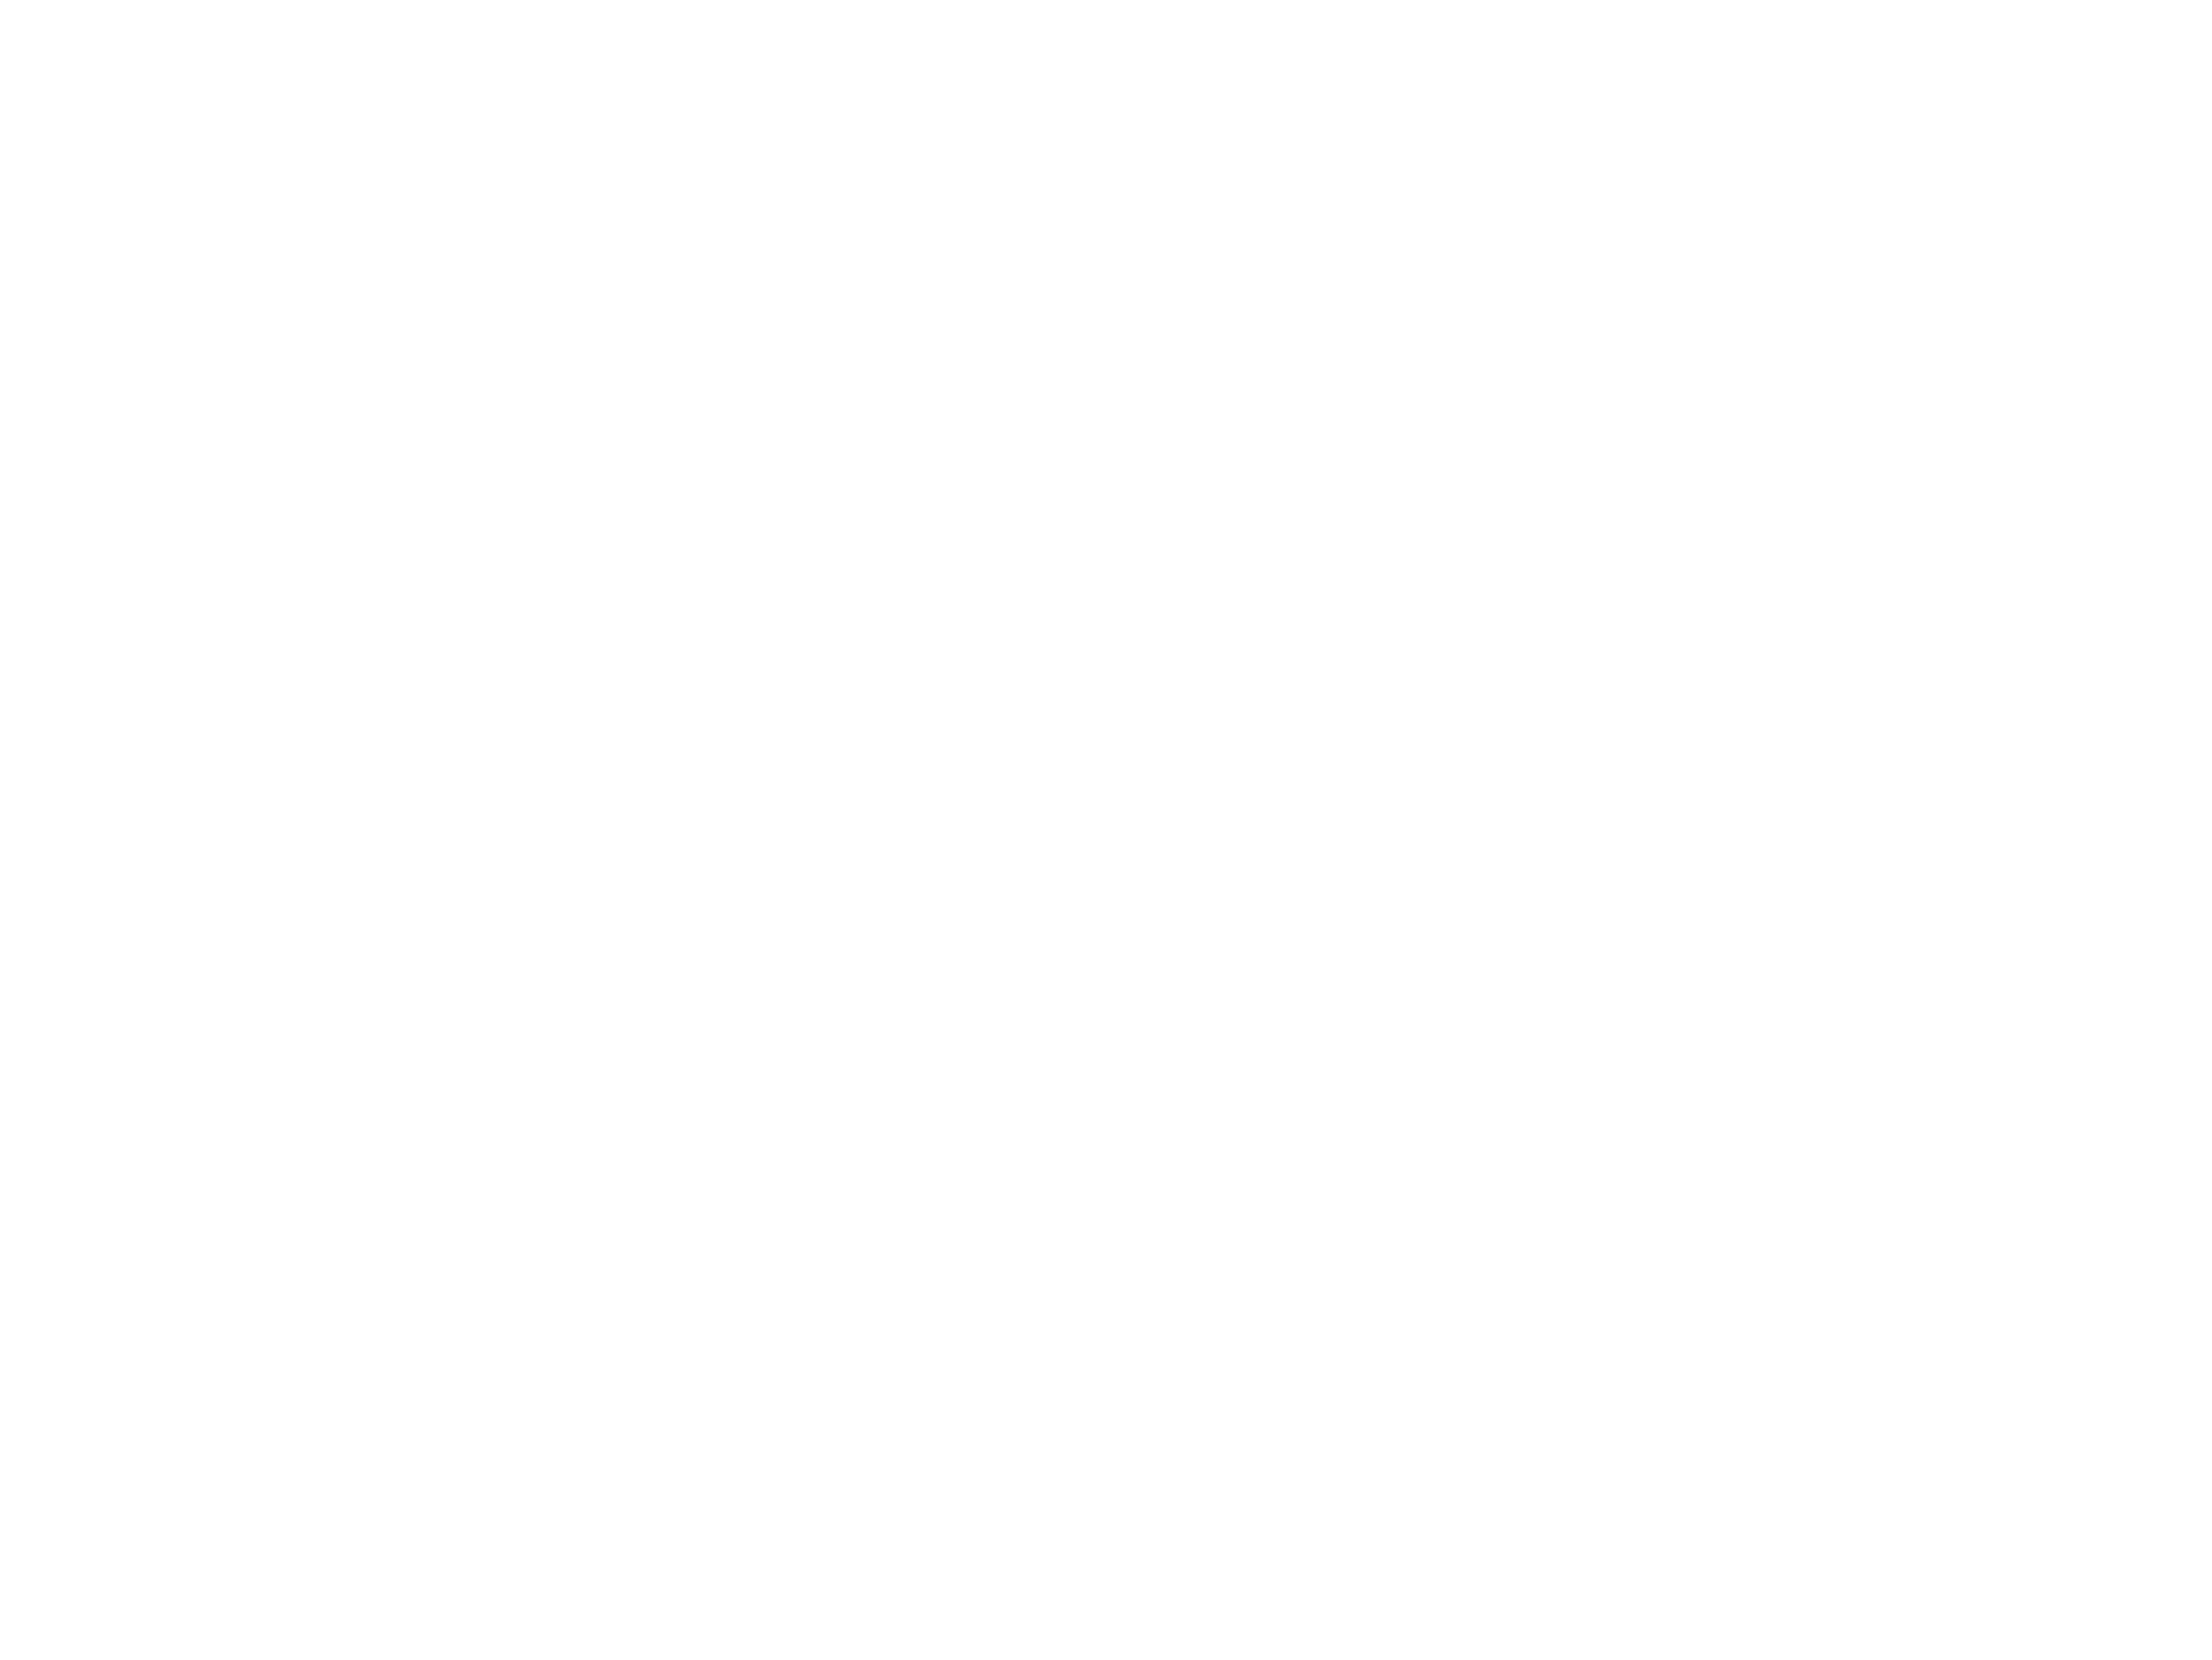

3250 
 0.1


In [35]:
#check for Fe I

plt.figure()
plt.plot(1.e8/nus[::-1],  op)
plt.yscale("log")
plt.xscale("log")
plt.show()
print(Tfix, '\n', Pfix)

# Compare with petitRADTRANS for METAL

written with reference to "[petitRadtran high-resolution IO.ipynb](https://gist.github.com/HajimeKawahara/69f633cfc29dffab913997a4b0e6a4c0)"

In [36]:
xrg = (11000, 11250) #(10000, 12000) 
yrg = (1e-27, 1e-17)

out_suffix = out_suffix #'_PH0.05' #'_crit120' #''
print(out_suffix)

_gf2600_Irw81_KA3s


### Case of exojax

In [37]:
petit_exojaxdir=path_pRT+"input_data/opacities/lines/line_by_line/Fe_exojax/"

with open(petit_exojaxdir+"wlen"+out_suffix+".dat", 'rb') as w:
    contentw = np.fromfile(w, dtype=np.float64)
    
fn_exo="sigma_99_3250.K_0.100000bar"+out_suffix+".dat"
#fn_exo="sigma_99_3162.2776601683795.K_0.100000bar"+out_suffix+".dat"
with open(petit_exojaxdir+fn_exo, 'rb') as f:
    contentf = np.fromfile(f, dtype=np.float64)
    
print(fn_exo)

sigma_99_3250.K_0.100000bar_gf2600_Irw81_KA3s.dat


<IPython.core.display.Javascript object>


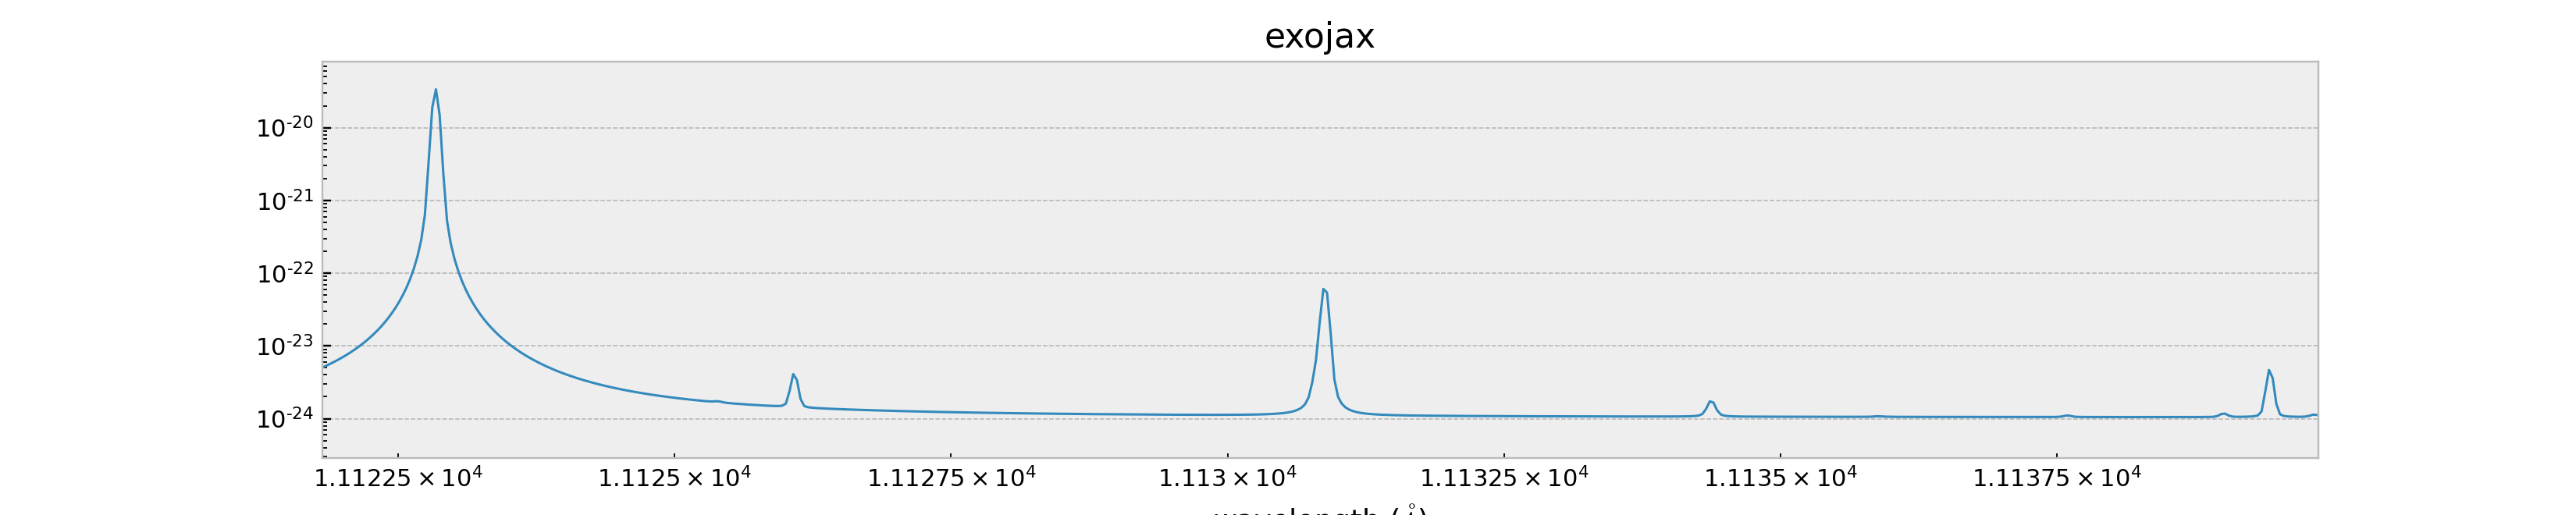

In [41]:
species_mass=Amol
xs=np.array(contentf)*species_mass*ucgs
wav=np.array(contentw,dtype=np.float64) #cm

fig=plt.figure(figsize=(15,3)) #(10,2.5)
plt.plot(wav*1.e8, xs, lw=1) #, label='(xH,xHe,xH2)=(0.05,0.005,0.1),')
#plt.plot(wav*1.e8, xs_sol, ':', lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84)')
plt.xlim(xrg)
plt.ylim(yrg)

plt.yscale("log")
plt.xscale("log") 
plt.title('exojax')
plt.xlabel("wavelength ($\AA$)")
#plt.legend()

plt.savefig(path_fig+'comp_exojax_Fe'+out_suffix+'.pdf') #comp_exojax_Fe_210823_gamma'+out_suffix+'.pdf
plt.show()

In [39]:
tu.nslack()
#---------------------------------------------------------------------------------

In [40]:
#check
out_suffix

'_gf2600_Irw81_KA3s'

In [24]:
#---------------------------------------------------------------------------------
print(Stop)

NameError: name 'Stop' is not defined

<IPython.core.display.Javascript object>


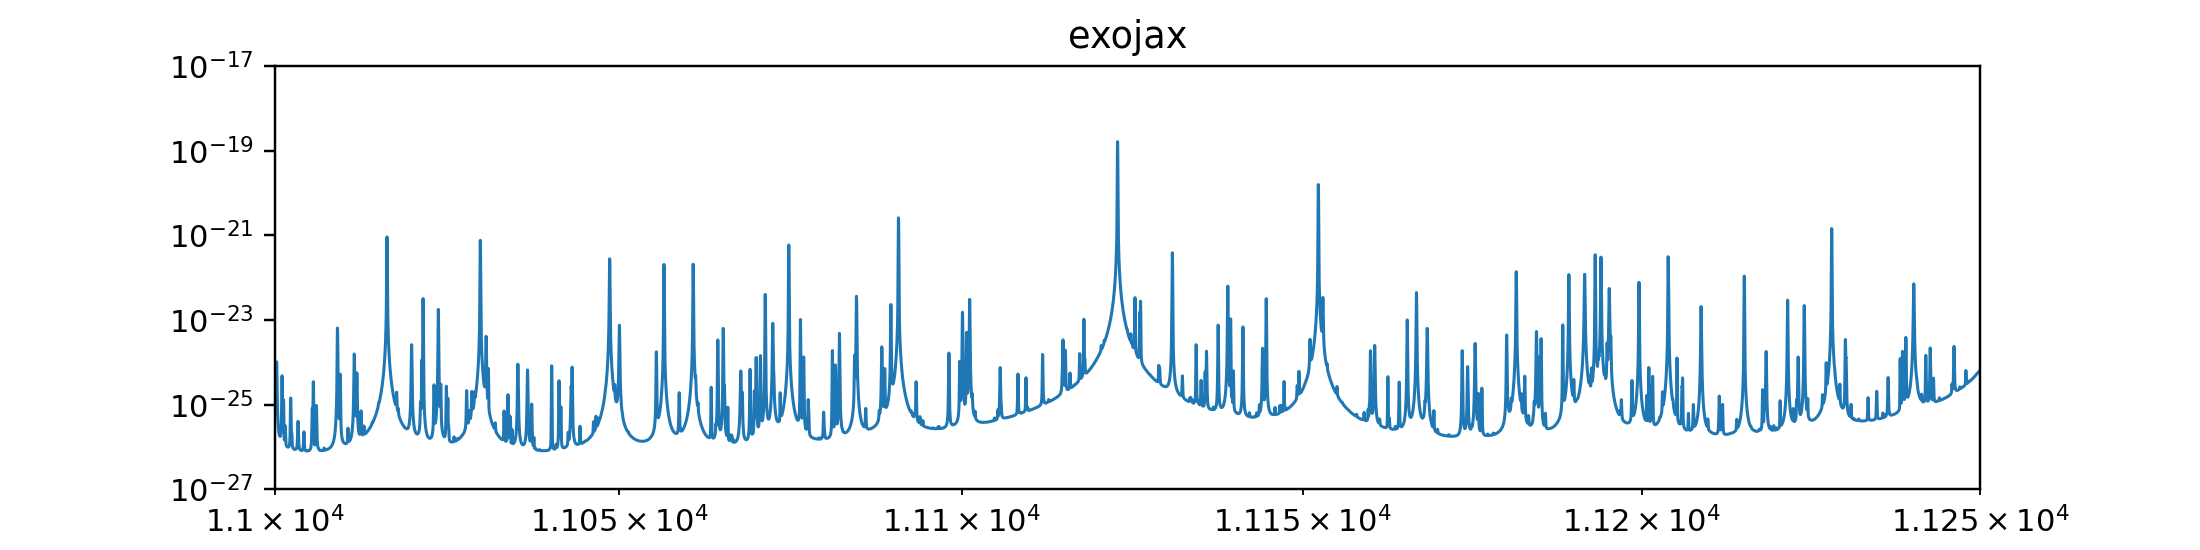

In [360]:
#BU
species_mass=Amol
xs=np.array(contentf)*species_mass*ucgs
wav=np.array(contentw,dtype=np.float64) #cm

fig=plt.figure(figsize=(10,2.5))
plt.plot(wav*1.e8, xs, lw=1) #, label='(xH,xHe,xH2)=(0.05,0.005,0.1),')
#plt.plot(wav*1.e8, xs_sol, ':', lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84)')
plt.xlim(xrg)
plt.ylim(yrg)

plt.yscale("log")
plt.xscale("log") 
plt.title('exojax')
plt.xlabel("wavelength ($\AA$)")
#plt.legend()

#plt.savefig(path_fig+'comp_exojax_Fe'+out_suffix+'.pdf') #comp_exojax_Fe_210823_gamma'+out_suffix+'.pdf
plt.show()

<IPython.core.display.Javascript object>


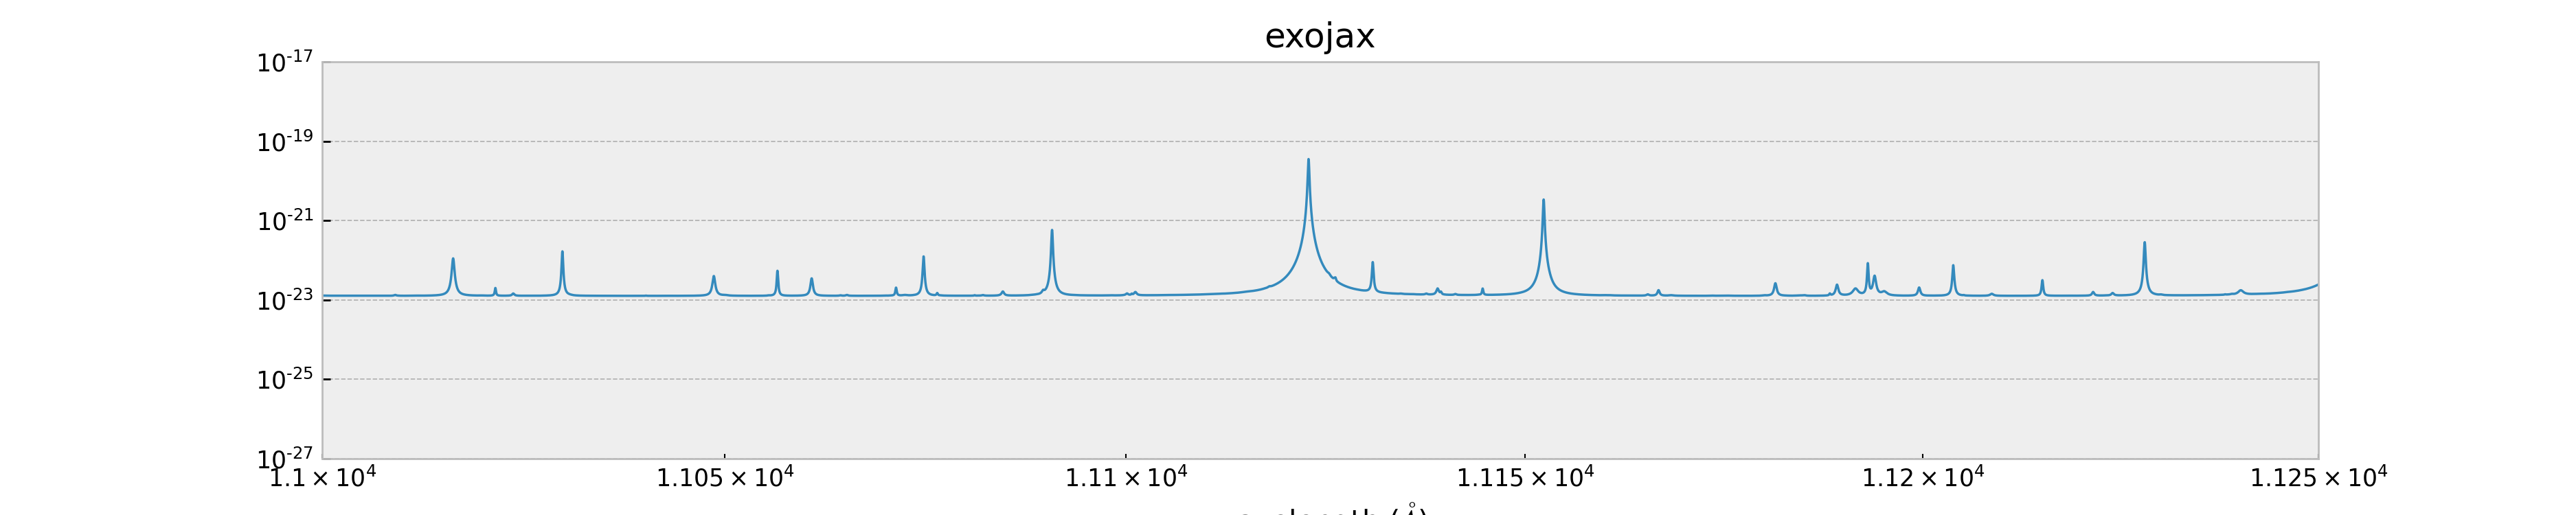

In [15]:
#BU

species_mass=55.847
xs=np.array(contentf)*species_mass*ucgs
wav=np.array(contentw,dtype=np.float64) #cm

fig=plt.figure(figsize=(15,3))
plt.plot(wav*1.e8, xs, lw=1) #, label='(xH,xHe,xH2)=(0.05,0.005,0.1),')
#plt.plot(wav*1.e8, xs_sol, ':', lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84)')
plt.xlim(xrg)
plt.ylim(yrg)

plt.yscale("log")
plt.xscale("log") 
plt.title('exojax')
plt.xlabel("wavelength ($\AA$)")
#plt.legend()

#plt.savefig(path_fig+'comp_exojax_Fe_210823_gamma'+out_suffix+'.pdf')
plt.show()

<IPython.core.display.Javascript object>


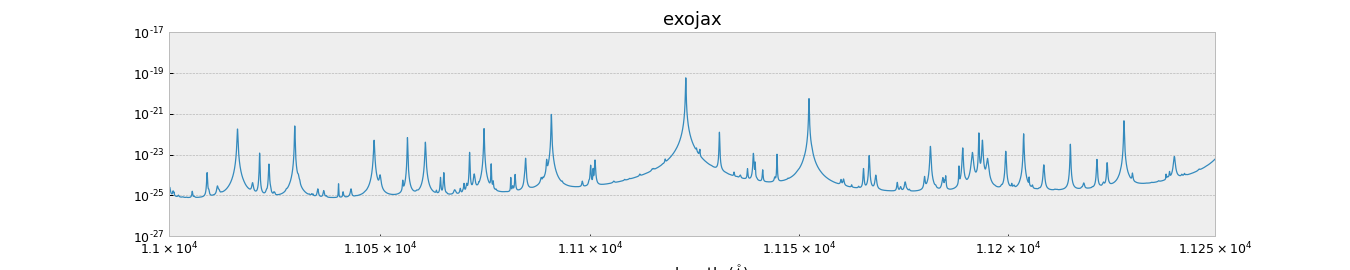

In [38]:
#BU


species_mass=55.847
xs=np.array(contentf)*species_mass*ucgs
wav=np.array(contentw,dtype=np.float64) #cm

fig=plt.figure(figsize=(15,3))
plt.plot(wav*1.e8, xs, lw=1) #, label='(xH,xHe,xH2)=(0.05,0.005,0.1),')
#plt.plot(wav*1.e8, xs_sol, ':', lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84)')
plt.xlim(xrg)
plt.ylim(yrg)

plt.yscale("log")
plt.xscale("log") 
plt.title('exojax')
plt.xlabel("wavelength ($\AA$)")
#plt.legend()

#plt.savefig(path_fig+'comp_exojax_Fe_210823_gamma'+out_suffix+'.pdf')
plt.show()

### Case of petitRADTRANS

In [181]:
petitdir=path_pRT+"input_data/opacities/lines/line_by_line/Fe/"

with open (petitdir+"wlen.dat") as w:
    contentw_p = np.fromfile(w, dtype=np.float64)
    
fn_pet="sigma_99_3250.K_0.100000bar.dat"
with open(petitdir+fn_pet, 'rb') as f:
    contentf_p = np.fromfile(f, dtype=np.float64)

<IPython.core.display.Javascript object>


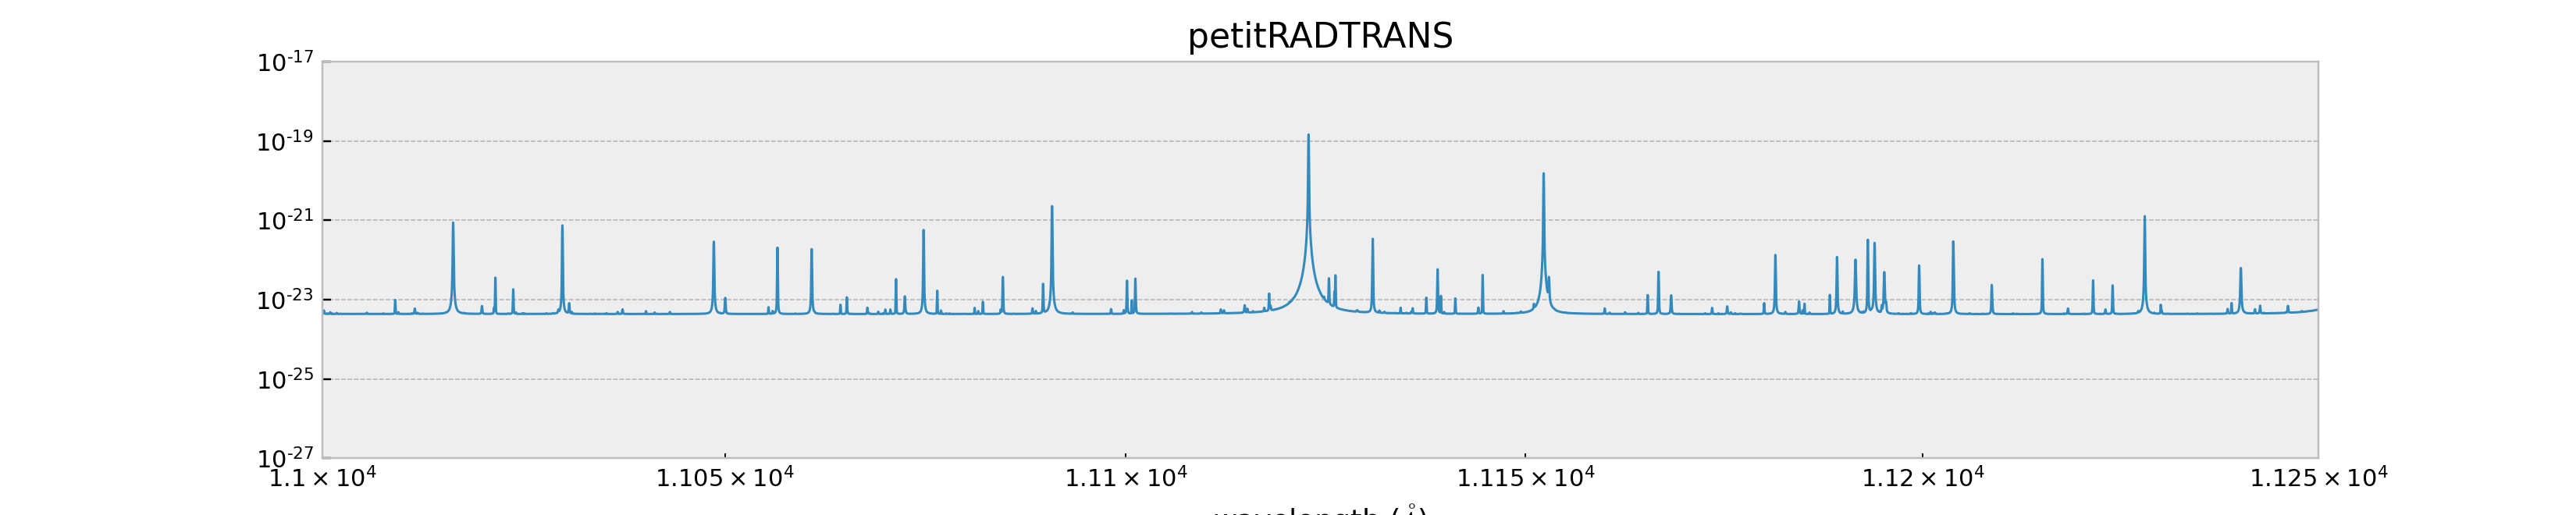

In [183]:
species_mass=Amol
xs_p=np.array(contentf_p)*species_mass*ucgs
wav_p=np.array(contentw_p,dtype=np.float64) #cm

fig=plt.figure(figsize=(15,3))
plt.plot(wav_p*1.e8, xs_p, lw=1)
plt.xlim(xrg)
plt.ylim(yrg)

plt.yscale("log")
plt.xscale("log") 
plt.title('petitRADTRANS')
plt.xlabel("wavelength ($\AA$)")

plt.show()
#plt.savefig(path_fig+'comp_petitR_Fe_211021.pdf')

### Difference

In [179]:
import scipy as sp
from matplotlib import gridspec

%matplotlib notebook
#%matplotlib inline

In [131]:
len( np.where((wav*1.e8>xrg[0]) & (wav*1.e8<xrg[1]))[0] ), len( np.where((wav_p*1.e8>xrg[0]) & (wav_p*1.e8<xrg[1]))[0] )

(24238, 22472)

In [193]:
wav_p_excerpt = wav_p[np.where((wav_p*1.e8>xrg[0]-1) & (wav_p*1.e8<xrg[1]+1))[0]]
xs_p_excerpt = xs_p[np.where((wav_p*1.e8>xrg[0]-1) & (wav_p*1.e8<xrg[1]+1))[0]]
wav_excerpt = wav[np.where((wav*1.e8>xrg[0]) & (wav*1.e8<xrg[1]))[0]]
xs_excerpt = xs[np.where((wav*1.e8>xrg[0]) & (wav*1.e8<xrg[1]))[0]]
xs_p_interp = sp.interpolate.interp1d(wav_p_excerpt, xs_p_excerpt, kind="quadratic")(wav_excerpt)

<IPython.core.display.Javascript object>


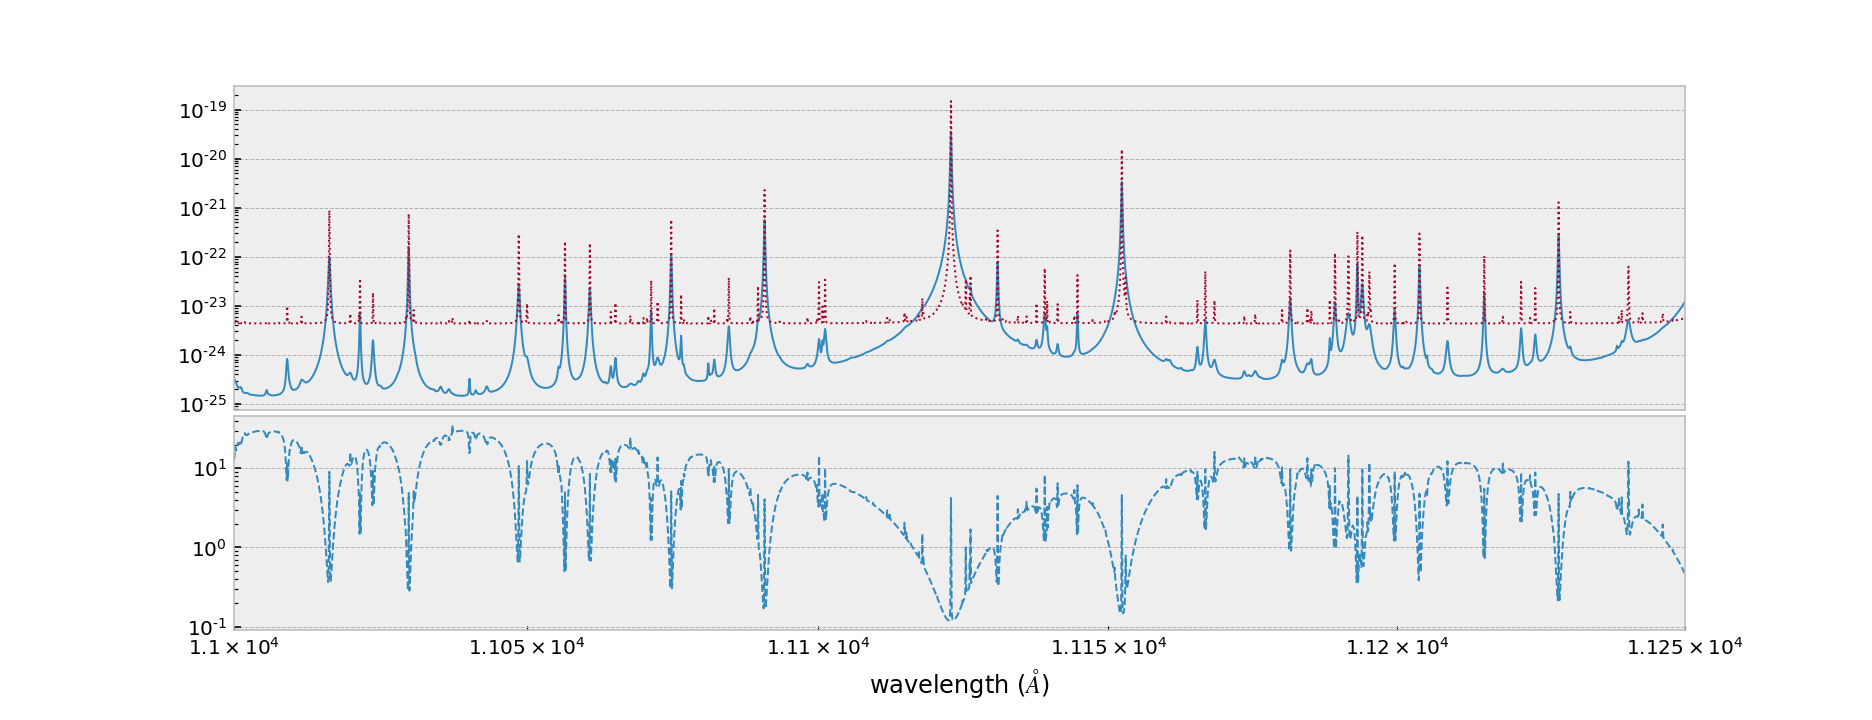

In [133]:
fig=plt.figure(figsize=(13,5)) #15, 5
gs=gridspec.GridSpec(5,1)
ax1=plt.subplot(gs[0:3])
ax2=plt.subplot(gs[3:], sharex=ax1)

ax1.plot(wav_excerpt*1.e8, xs_excerpt, lw=1)
ax1.plot(wav_excerpt*1.e8, xs_p_interp, ':', lw=1)
ax2.plot(wav_excerpt*1.e8, xs_p_interp/xs_excerpt, '--', lw=1)

ax1.set_xlim(xrg)
#ax1.set_ylim(yrg)

ax1.set_xscale("log")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.axes.xaxis.set_visible(False)
ax2.set_xlabel("wavelength ($\AA$)")

plt.subplots_adjust(hspace=.05)
plt.show()
#plt.savefig(path_fig+'comp_diff_Fe'+out_suffix+'.pdf')

### Comparison with opacity calculated by Kawashima-san
- Pressure broadeningはKurucz & Avrett (1981)の式  
- VMRを変えて2パターン："ishikawa-frac"=(xH,xHe,xH2)=(0.05,0.005,0.1), "solar-frac"=(xH,xHe,xH2)=(0.0,0.16,0.84)（この温度・圧力での太陽組成の場合の化学平衡組成ではありませんが、低温の時には大体この値なのでsolarと付けています）
- Feの原子量は55.845、イオン化エネルギーは7.9024 [eV]
- 分配関数は、Irwin (1981)の多項式展開
- Kuruczのline list（リンク先のgf2600.all）を使ったのですが、全transition45,118本中、（バグなのか）上と下の準位が逆転しているものが半分以上の24,696本もありました。VALDの方や石川君が計算する時にどうしたか知らないのですが、ファイル名に"excluded"と付いているものはそれらの遷移を単純に除外し、"inverted"と付いているものはエネルギー準位の高い方が上だと思って逆転させて使用しました。

#\kawashima-san\

In [23]:
ko_ish_wo_VIS = np.loadtxt('Fe_0.1bar-3250K_inverted_ishikawa-frac_wo-optical-lines.dat', comments='#')
ko_sol_inverted = np.loadtxt('Fe_0.1bar-3250K_inverted_solar-frac.dat', comments='#')
ko_sol_excluded = np.loadtxt('Fe_0.1bar-3250K_excluded_solar-frac.dat', comments='#')
ko_ish_inverted = np.loadtxt('Fe_0.1bar-3250K_inverted_ishikawa-frac.dat', comments='#')
ko_ish_excluded = np.loadtxt('Fe_0.1bar-3250K_excluded_ishikawa-frac.dat', comments='#')
ko_11973_10000K = np.loadtxt('Fe_10000K_0.1bar_only_11973A.dat', comments='#')
ko_takoself = np.loadtxt('/home/tako/Dropbox/Ipynb/kurucz_atoms/Fe_10000K_0.1bar_only_11973A.dat', comments='#')

#### partition function from Irwin (1981)

In [24]:
def partfn_Fe(T):
    #Irwin_1981
    a=np.zeros(6)
    a[0]=-1.15609527e3
    a[1]= 7.46597652e2
    a[2]=-1.92865672e2
    a[3]= 2.49658410e1
    a[4]=-1.61934455e0
    a[5]= 4.21182087e-2

    Qln=0.0
    for i, a in enumerate(a):
        Qln = Qln + a*np.log(T)**i
    Q = np.exp(Qln)
    return(Q)

In [25]:
#check by p.4 of Irwin_1981
np.log(partfn_Fe(16000)) 

5.6213895622809105

In [13]:
#分配関数の比較
atomspecies = "Fe 1"

print('\t Barklem_2016')
print(adbFe.QT_interp(atomspecies, Tfix), adbFe.QT_interp(atomspecies, adbFe.Tref), )
print(adbFe.QT_interp(atomspecies, Tfix) / adbFe.QT_interp(atomspecies, adbFe.Tref),)
print(adbFe.qr_interp("Fe 1", Tfix))

print('\t Irwin_1981')
print(partfn_Fe(Tfix), partfn_Fe(adbFe.Tref), )
print(partfn_Fe(Tfix) / partfn_Fe(adbFe.Tref), )

	 Barklem_2016
62.6312122241853 2.2402536896329703
27.957196327370593
27.957196327370593
	 Irwin_1981
62.6312122241853 2.2402536896329703
27.957196327370593


#### wavelength converter (air or vacuum)

In [26]:
# Convert wavelength [Angstrom] to vacuum (from air)
#'''
def air_to_vac(wavelength):
    """[specutils](https://github.com/astropy/specutils/blob/0933a8e271ab1e333337087433cb683da8ab5a54/specutils/utils/wcs_utils.py#L366  )
    Implements the air to vacuum wavelength conversion described in eqn 65 of
    Griesen 2006
    """
    wlum = wavelength.to(u.um).value
    return (1+1e-6*(287.6155+1.62887/wlum**2+0.01360/wlum**4)) * wavelength
from astropy import units as u
wav_yk = air_to_vac(ko_sol_inverted[:, 0] * 1e4 * u.um).value
#'''
def wavelength_air_to_vacuum(WL_air): 
    """[VALD Documentation](https://www.astro.uu.se/valdwiki/Air-to-vacuum%20conversion)
    """
    n_pre = 1.0 + 0.0000834254 + (0.02406147 / (130.0 - (WL_air*1.000274*0.0001)**2.0)) + (0.00015998 / (38.9 - (WL_air*1.000274*0.0001)**2.0))
    n = 1.0 + 0.0000834254 + (0.02406147 / (130.0 - (WL_air*n_pre*0.0001)**2.0)) + (0.00015998 / (38.9 - (WL_air*n_pre*0.0001)**2.0))
    return(WL_air * n)

wav_yk = np.array(list(map(wavelength_air_to_vacuum, ko_sol_inverted[:, 0] * 1e4)))

In [27]:
#川島さんの波長
wavelength_air_to_vacuum(10002.328)
11983.0052/wavelength_air_to_vacuum(11983.0052)*11983.0052

11979.71254805769

In [28]:
#川島さんの波長
wavelength_air_to_vacuum(11973.048)

11976.338775320144

#### vs petitRADTRANS

<IPython.core.display.Javascript object>


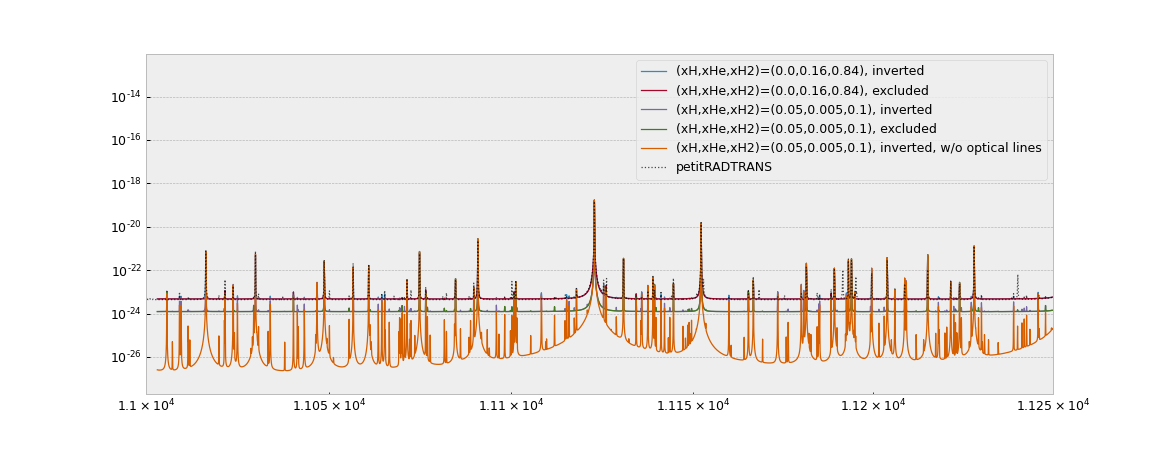

In [96]:
fig=plt.figure(figsize=(13,5)) #15, 5

plt.plot(wav_yk, ko_sol_inverted[:,1], lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), inverted')
plt.plot(wav_yk, ko_sol_excluded[:,1], lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), excluded')
plt.plot(wav_yk, ko_ish_inverted[:,1], lw=1, label='(xH,xHe,xH2)=(0.05,0.005,0.1), inverted')
plt.plot(wav_yk, ko_ish_excluded[:,1], lw=1, label='(xH,xHe,xH2)=(0.05,0.005,0.1), excluded')

plt.plot(wav_yk, ko_ish_wo_VIS[:,1], lw=1, label='(xH,xHe,xH2)=(0.05,0.005,0.1), inverted, w/o optical lines')
plt.plot(wav_p*1.e8, xs_p, 'k', linestyle=':', lw=1, alpha=0.7, label='petitRADTRANS')

plt.xlim(11000, 11250)
plt.yscale("log")
plt.xscale("log") 
plt.legend()
#plt.savefig(path_fig+'comp_diff_Fe'+'_yk_and_pRT'+'.pdf') #out_suffix
plt.show()

#### vs exojax
This is the important figure for the sanity check...

In [361]:
xrg = (11000, 11250)

In [362]:
petit_exojaxdir=path_pRT+"input_data/opacities/lines/line_by_line/Fe_exojax/"

species_mass=55.847

with open(petit_exojaxdir+"wlen.dat", 'rb') as w:
    contentw = np.fromfile(w, dtype=np.float64)
wav=np.array(contentw,dtype=np.float64) #cm
index_excerpt = np.where((wav*1.e8>xrg[0]) & (wav*1.e8<xrg[1]))[0]
wav_ex = wav[index_excerpt]

with open(petit_exojaxdir+"wlen_4204004.dat", 'rb') as w:
    contentw = np.fromfile(w, dtype=np.float64)
wav_4204004=np.array(contentw,dtype=np.float64) #cm
index_4204004ex = np.where((wav_4204004*1.e8>xrg[0]) & (wav_4204004*1.e8<xrg[1]))[0]
wav_4204004ex = wav_4204004[index_4204004ex]

with open(petit_exojaxdir+"wlen_4204595.dat", 'rb') as w:
    contentw = np.fromfile(w, dtype=np.float64)
wav_4204595=np.array(contentw,dtype=np.float64) #cm
index_4204595ex = np.where((wav_4204595*1.e8>xrg[0]) & (wav_4204595*1.e8<xrg[1]))[0]
wav_4204595ex = wav_4204595[index_4204595ex]

with open(petit_exojaxdir+"wlen_4204596.dat", 'rb') as w:
    contentw = np.fromfile(w, dtype=np.float64)
wav_4204596=np.array(contentw,dtype=np.float64) #cm
index_4204596ex = np.where((wav_4204596*1.e8>xrg[0]) & (wav_4204596*1.e8<xrg[1]))[0]
wav_4204596ex = wav_4204596[index_4204596ex]

'''
fn_exo_sol="sigma_99_3162.2776601683795.K_0.100000bar_PHsolar.dat"
with open(petit_exojaxdir+fn_exo_sol, 'rb') as f:
    contentf = np.fromfile(f, dtype=np.float64)
xs_sol=np.array(contentf)*species_mass*ucgs
xs_sol_excerpt = xs_sol[index_excerpt]

fn_exo_ish="sigma_99_3162.2776601683795.K_0.100000bar_PH0.05.dat"
with open(petit_exojaxdir+fn_exo_ish, 'rb') as f:
    contentf = np.fromfile(f, dtype=np.float64)
xs_ish=np.array(contentf)*species_mass*ucgs
xs_ish_excerpt = xs_ish[index_excerpt]
#'''

fn_exo_test="sigma_99_3162.2776601683795.K_0.100000bar_PHsolar.dat" #3000–12000Å
with open(petit_exojaxdir+fn_exo_test, 'rb') as f:
    contentf = np.fromfile(f, dtype=np.float64)
xs_wopt10000=np.array(contentf)*species_mass*ucgs #with optical wavelength
xs_wopt10000ex = xs_wopt10000[index_4204004ex]

fn_exo_test="sigma_99_3162.2776601683795.K_0.100000bar_PH_4204595.dat" #3000–12000Å
with open(petit_exojaxdir+fn_exo_test, 'rb') as f:
    contentf = np.fromfile(f, dtype=np.float64)
xs_wopt3000=np.array(contentf)*species_mass*ucgs #with optical wavelength
xs_wopt3000ex = xs_wopt3000[index_4204595ex]

'''
fn_exo_test="sigma_99_3162.2776601683795.K_0.100000bar_PH_4204595_ghalftmp.dat" #Half-gammaL  
with open(petit_exojaxdir+fn_exo_test, 'rb') as f:
    contentf = np.fromfile(f, dtype=np.float64)
xs_ghalf=np.array(contentf)*species_mass*ucgs #make gammaL half
#xs_ghalf_excerpt = xs_ghalf[index_excerpt]

fn_exo_test="sigma_99_3162.2776601683795.K_0.100000bar_PH_4204595_opt.dat" #only optical?
with open(petit_exojaxdir+fn_exo_test, 'rb') as f:
    contentf = np.fromfile(f, dtype=np.float64)
xs_opt=np.array(contentf)*species_mass*ucgs #make gammaL half
#'''

fn_exo_test="sigma_99_3162.2776601683795.K_0.100000bar_PH_4204596.dat" #100–12000Å
with open(petit_exojaxdir+fn_exo_test, 'rb') as f:
    contentf = np.fromfile(f, dtype=np.float64)
xs_wopt=np.array(contentf)*species_mass*ucgs #with optical wavelength
xs_woptex = xs_wopt[index_4204596ex]



fn_exo_test="sigma_99_3162.2776601683795.K_0.100000bar_11to13_takofrac.dat" #100–12000Å
with open(petit_exojaxdir+fn_exo_test, 'rb') as f:
    contentf = np.fromfile(f, dtype=np.float64)
xs_takofrac=np.array(contentf)*species_mass*ucgs #with optical wavelength


xs_ex=xs[index_excerpt]


In [351]:
xs.shape, wav.shape, xs_takofrac.shape, wav_4204596ex.shape, wav_4204595ex.shape, wav_4204004ex.shape

((230770,), (230770,), (139861,), (20202,), (20202,), (24238,))

In [363]:
xs_ex.shape, wav_ex.shape


((20202,), (20202,))

In [330]:
xrg = (11115, 11130)

<IPython.core.display.Javascript object>


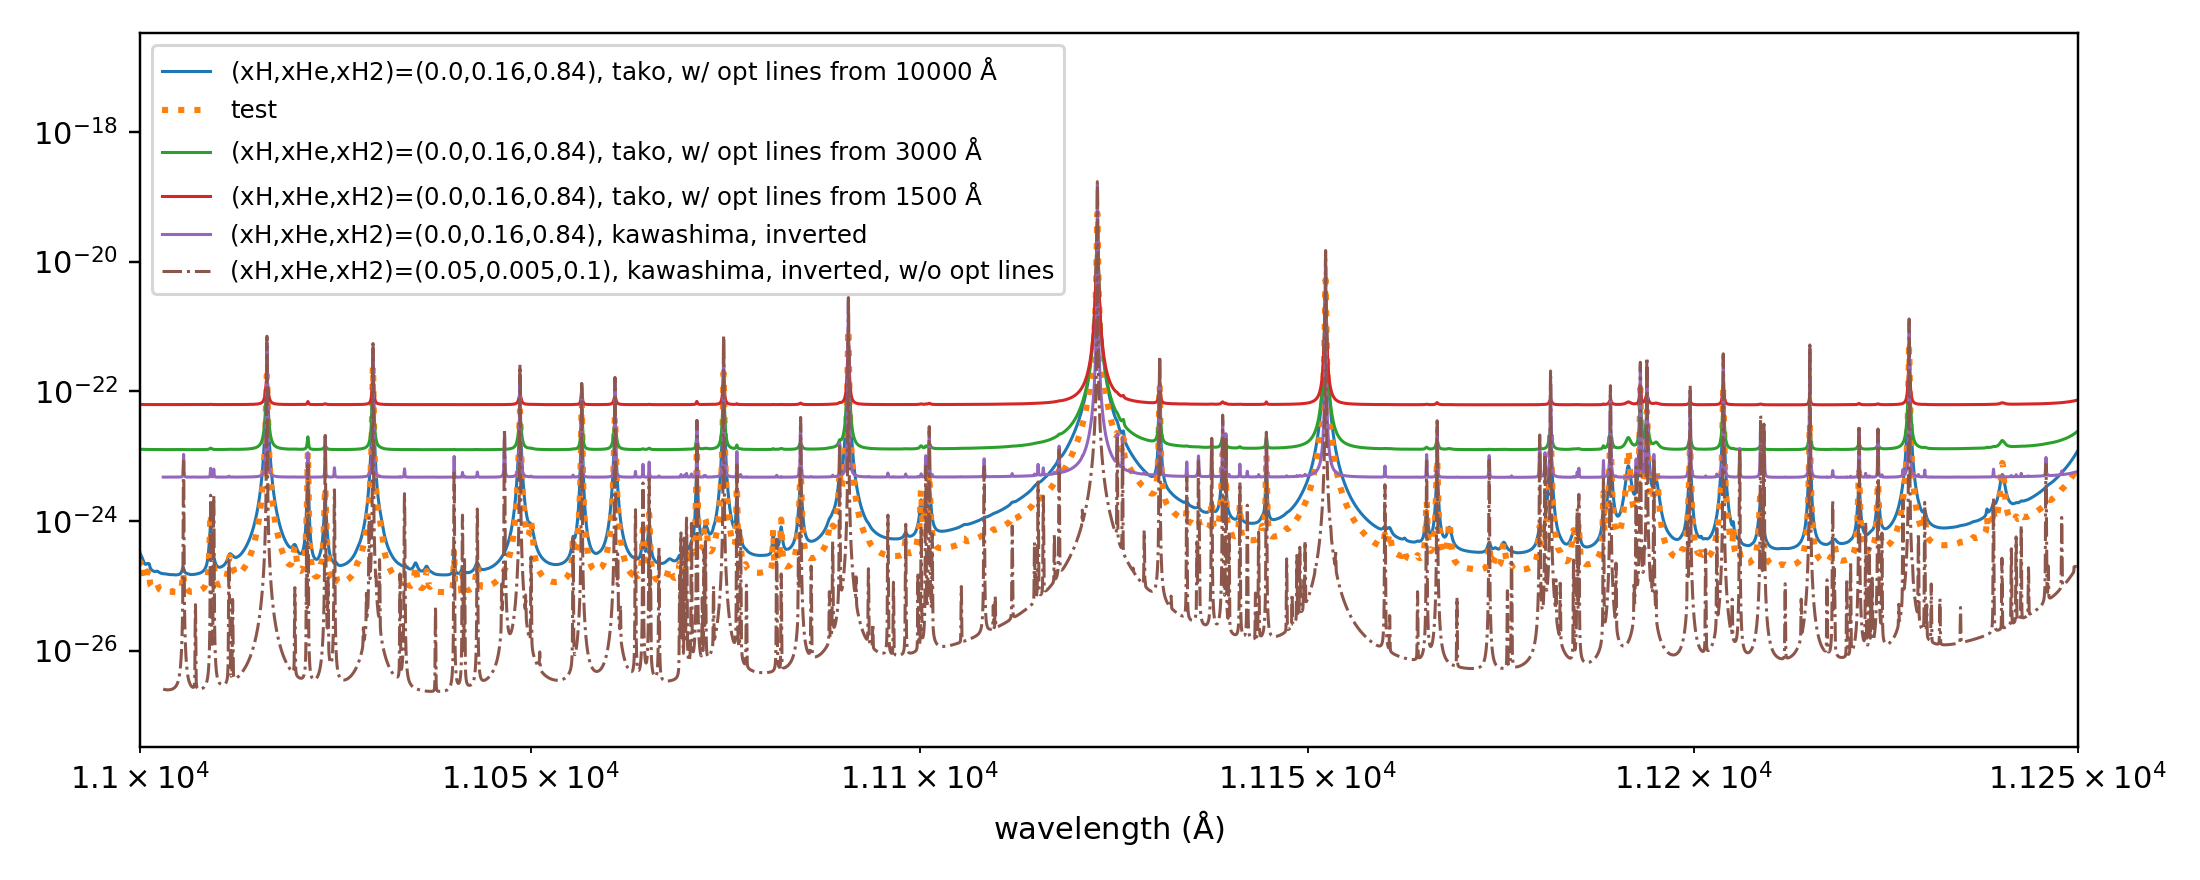

In [87]:
fig, ax1=plt.subplots(figsize=(10,4), tight_layout=True) #15, 5

#ax1.plot(wav_excerpt*1.e8, xs_excerpt, lw=1, label='tako')
#ax1.plot(wav_excerpt*1.e8, xs_p_interp, ':', lw=1, label='petitRADTRANS')

#ax1.plot(wav_excerpt*1.e8, xs_ish_excerpt, lw=1, label='(xH,xHe,xH2)=(0.05,0.005,0.1), tako')
#ax1.plot(wav_excerpt*1.e8, xs_sol_excerpt, lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), tako')
#ax1.plot(wav_excerpt*1.e8, xs_excerpt, lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), tako, Unsöld')
#ax1.plot(wav_excerpt*1.e8, xs_wopt_excerpt, lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), tako, w/ opt lines')
#ax1.plot(wav_excerpt*1.e8, xs_ghalf_excerpt, lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), tako, half-gamma')


ax1.plot(wav_4204004ex*1.e8, xs_wopt10000ex, lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), tako, w/ opt lines from 10000 $\mathrm{\AA}$')
ax1.plot(wav*1.e8, xs, lw=2, linestyle=':', label='test') #, label='(xH,xHe,xH2)=(0.05,0.005,0.1),')
ax1.plot(wav_4204595ex*1.e8, xs_wopt3000ex, lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), tako, w/ opt lines from 3000 $\mathrm{\AA}$')
ax1.plot(wav_4204596ex*1.e8, xs_woptex, lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), tako, w/ opt lines from 1500 $\mathrm{\AA}$')

#ax1.plot(wav_yk, ko_ish_inverted[:,1], lw=1, label='(xH,xHe,xH2)=(0.05,0.005,0.1), inverted')
ax1.plot(wav_yk, ko_sol_inverted[:,1], lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), kawashima, inverted')
ax1.plot(wav_yk, ko_ish_wo_VIS[:,1], '-.', lw=1, label='(xH,xHe,xH2)=(0.05,0.005,0.1), kawashima, inverted, w/o opt lines')

ax1.set_xlim(xrg)
#ax1.set_ylim(yrg)

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("wavelength ($\mathrm{\AA}$)")
ax1.legend(fontsize=8)

#plt.subplots_adjust(hspace=.05)
#plt.savefig(path_fig+'comp_diff_Fe'+'_optical_from_different_wav'+'.pdf') #out_suffix
plt.show()

In [70]:
plt.savefig(path_fig+'comp_diff_Fe'+'_optical_from_different_wav_zoomin_'+'.pdf') #out_suffix

#### 川島さんが計算してくださった範囲に合わせて比較
\here\

##### test three cases

In [183]:
#xrg = (11800, 12200)
xrg = (11500, 12500)

out_suffix #= '_only_11973A'
out_suffix #= '_only_11973A_Irwin1981'
out_suffix #= '_only_11973A_Irwin1981_air'
#out_suffix = '_only_11973A_Irwin1981_air_Irwin1981'
#
#out_suffix = '_only_11973A_air_Irwin1981'
#out_suffix = '_only_11973A_air_Barklem2016'

In [163]:
wav_ko_11973_10000Kair = ko_11973_10000K[:, 0] * 1e4
wav_ko_11973_10000Kvac = wavelength_air_to_vacuum(ko_11973_10000K[:, 0] * 1e4)
wav_ko_11973_10000Kaiv = air_to_vac(ko_11973_10000K[:, 0] * 1e4  * u.angstrom)

#---------------------------------------------------------------------------------
wav_ko_11973_10000Kselect = wav_ko_11973_10000Kair
#---------------------------------------------------------------------------------

tmpdelID = np.where(wav_ko_11973_10000Kselect - np.delete(np.insert(wav_ko_11973_10000Kselect, 0, 0), -1, 0) < 0)[0]
for idel in tmpdelID:
    wav_ko_11973_10000Kselect[idel-100:idel+100] = np.median(wav_ko_11973_10000Kselect[idel-1000:idel+1000])
    
index_ko_excerpt = np.where((wav_ko_11973_10000Kselect>xrg[0]) & (wav_ko_11973_10000Kselect<xrg[1]))[0]
wav_ko_11973_10000K_ex = wav_ko_11973_10000Kselect[index_ko_excerpt]
flx_ko_11973_10000K_ex=ko_11973_10000K[:,1][index_ko_excerpt]

<IPython.core.display.Javascript object>


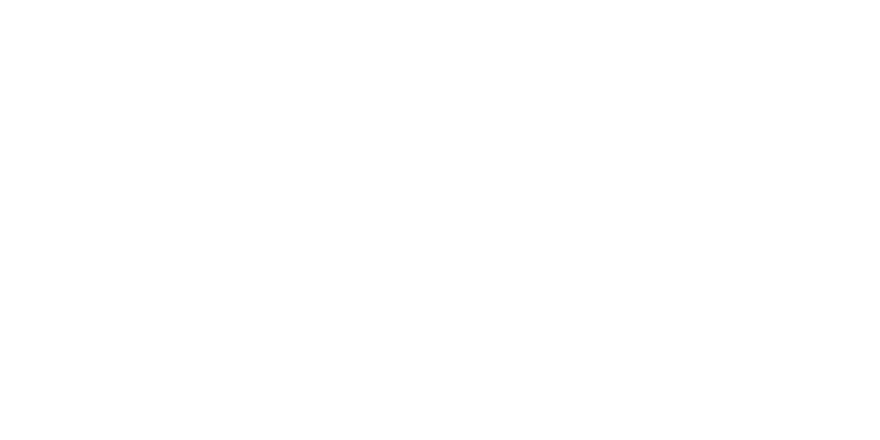

In [164]:
fig, ax1=plt.subplots(figsize=(4,2), tight_layout=True) #15, 5

#Makeshift first aid
plt.plot(wav_ko_11973_10000Kselect, ko_11973_10000K[:,1], \
         lw=1, alpha=0.8, label='(xH,xHe,xH2)=(1.0,0.0,0.0), 10000 K, 0.1 bar, only 11973A, from Kawashima-san')
plt.plot(wav_ko_11973_10000Kaiv, ko_11973_10000K[:,1], \
         lw=1, alpha=0.8, label='(xH,xHe,xH2)=(1.0,0.0,0.0), 10000 K, 0.1 bar, only 11973A, from Kawashima-san')
plt.plot(wav_ko_11973_10000K_ex, flx_ko_11973_10000K_ex, \
         lw=1, alpha=0.8, label='(xH,xHe,xH2)=(1.0,0.0,0.0), 10000 K, 0.1 bar, only 11973A, from Kawashima-san', color='gold', ls='--')

ax1.set_xscale("log")
ax1.set_yscale("log")
plt.show()


plt.close()

In [184]:
petit_exojaxdir=path_pRT+"input_data/opacities/lines/line_by_line/Fe_exojax/"

with open(petit_exojaxdir+"wlen"+out_suffix+".dat", 'rb') as w:
    contentw = np.fromfile(w, dtype=np.float64)
    wav=np.array(contentw,dtype=np.float64) #cm
    
species_mass=55.845 #55.847
fn_exo0="sigma_99_10000.K_0.100000bar"+out_suffix+".dat"
fn_exo2="sigma_99_10000.K_0.100000bar"+out_suffix+"2.dat"
fn_exo3="sigma_99_10000.K_0.100000bar"+out_suffix+"3.dat"
fn_exo4="sigma_99_10000.K_0.100000bar"+out_suffix+"4.dat"
fn_exo5="sigma_99_10000.K_0.100000bar"+out_suffix+"5.dat"
fn_exo6="sigma_99_10000.K_0.100000bar"+out_suffix+"6.dat"

with open(petit_exojaxdir+fn_exo0, 'rb') as f:
    xs0=np.array(np.fromfile(f, dtype=np.float64))*species_mass*ucgs
with open(petit_exojaxdir+fn_exo2, 'rb') as f:
    xs2=np.array(np.fromfile(f, dtype=np.float64))*species_mass*ucgs
with open(petit_exojaxdir+fn_exo3, 'rb') as f:
    xs3=np.array(np.fromfile(f, dtype=np.float64))*species_mass*ucgs
with open(petit_exojaxdir+fn_exo4, 'rb') as f:
    xs4=np.array(np.fromfile(f, dtype=np.float64))*species_mass*ucgs
with open(petit_exojaxdir+fn_exo5, 'rb') as f:
    xs5=np.array(np.fromfile(f, dtype=np.float64))*species_mass*ucgs
with open(petit_exojaxdir+fn_exo6, 'rb') as f:
    xs6=np.array(np.fromfile(f, dtype=np.float64))*species_mass*ucgs

index_excerpt = np.where((wav*1.e8>xrg[0]) & (wav*1.e8<xrg[1]))[0]
wav_ex = wav[index_excerpt]
xs0_ex=xs0[index_excerpt]
xs2_ex=xs2[index_excerpt]
xs3_ex=xs3[index_excerpt]
xs4_ex=xs4[index_excerpt]
xs5_ex=xs5[index_excerpt]
xs6_ex=xs6[index_excerpt]


<IPython.core.display.Javascript object>


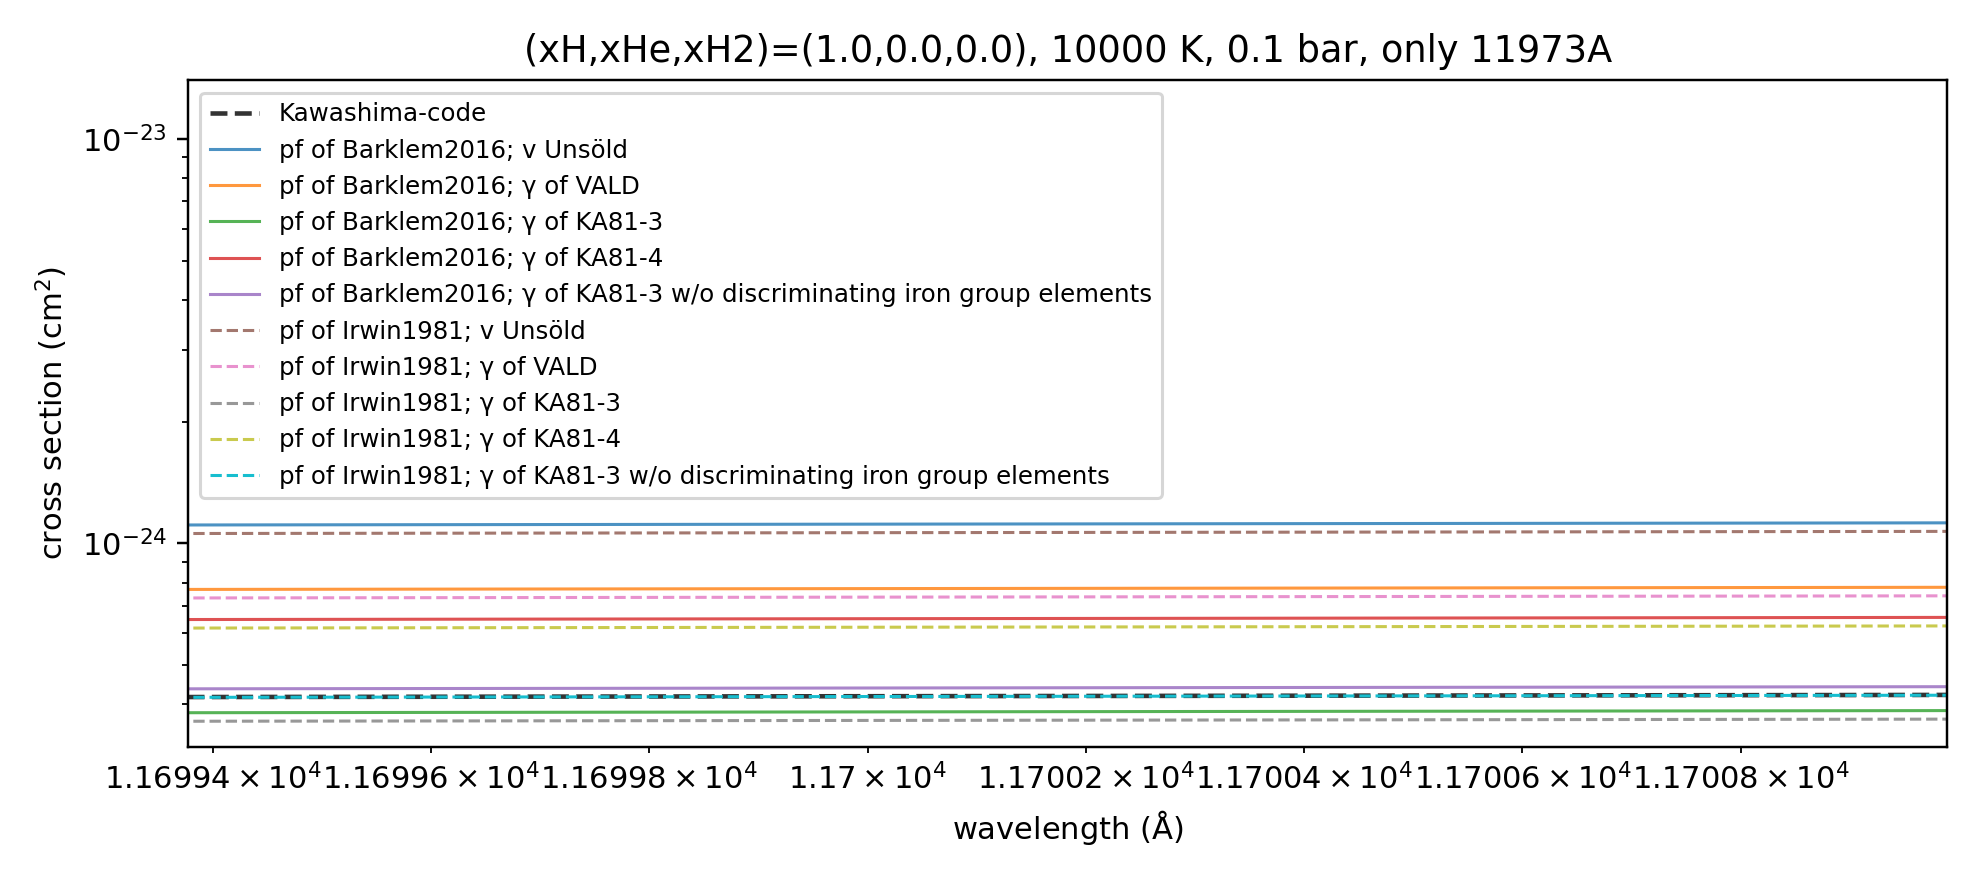

In [185]:
fig, ax1=plt.subplots(figsize=(9,4), tight_layout=True) #15, 5
ax1.set_title('(xH,xHe,xH2)=(1.0,0.0,0.0), 10000 K, 0.1 bar, only 11973A')

ax1.plot(wav_ko_11973_10000K_ex, flx_ko_11973_10000K_ex, \
         color='k', ls='--', lw=1.5, alpha=0.8, label='Kawashima-code')
#ax1.plot(wav_yk, ko_sol_inverted[:,1], lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), kawashima, inverted') #, alpha=0.0)#
#ax1.plot(wav_yk, ko_ish_wo_VIS[:,1], '-', lw=0.5, label='(xH,xHe,xH2)=(0.05,0.005,0.1), kawashima, inverted, w/o opt lines', alpha=0.8)
#, color='C1'
#ax1.plot(wav*1.e8, xsyobi, 'k', lw=1, linestyle='-', alpha=0.8, label='(xH,xHe,xH2)=(0.0,0.16,0.84), testingexojax, w/o opt lines')
#ax1.plot(wav*1.e8, xs_takofrac, 'c', lw=1, linestyle='-', alpha=0.8, label='(xH,xHe,xH2)=(0.05,0.005,0.1), testingexojax, w/o opt lines')
#ax1.plot(wav*1.e8, xsyobi2, 'slateblue', lw=1, linestyle='-', alpha=0.8, label='(xH,xHe,xH2)=(0.0,0.0016,0.0084), testingexojax, w/o opt lines')

#addition = ' sigmaDrev'
#addition = ' part.func. of Irwin1981,  gammaL/(4*np.pi)'
#pre = 'part.func. of Barklem2016; '
pre = 'pf of Barklem2016; '
#ax1.plot(wav_ex*1.e8, xs0_ex, lw=1, linestyle='-', alpha=0.8, label=addition+'')
ax1.plot(wav_ex*1.e8, xs2_ex, lw=1, linestyle='-', alpha=0.8, label=pre+'v Unsöld')
ax1.plot(wav_ex*1.e8, xs3_ex, lw=1, linestyle='-', alpha=0.8, label=pre+'γ of VALD') #, color='gold')
ax1.plot(wav_ex*1.e8, xs4_ex, lw=1, linestyle='-', alpha=0.8, label=pre+'γ of KA81-3')
ax1.plot(wav_ex*1.e8, xs5_ex, lw=1, linestyle='-', alpha=0.8, label=pre+'γ of KA81-4')
ax1.plot(wav_ex*1.e8, xs6_ex, lw=1, linestyle='-', alpha=0.8, label=pre+'γ of KA81-3 w/o discriminating iron group elements')
#ax1.plot(wav_ex*1.e8, xs_ex, lw=1, linestyle='-', alpha=0.8, label='test')#, 'r'
#ax1.plot(wav*1.e8, xs, lw=1, linestyle='-', alpha=0.8, label='test')#, 'r'

ax1.set_xscale("log") 
ax1.set_yscale("log")
ax1.set_xlabel("wavelength ($\mathrm{\AA}$)")
ax1.set_ylabel("cross section ($\mathrm{cm^2}$)")
#ax1.set_xlim(11000, 13000)
#ax1.set_xlim(11971.6, 11973.2)
#ax1.set_xlim(11976.3233-10, 11976.3233+10)
ax1.set_xlim(11953, 11974)
ax1.set_ylim(5e-23, 4e-16)
ax1.legend(fontsize=8, loc='upper left')

#plt.subplots_adjust(hspace=.05)
#plt.savefig(path_fig+'comp_diff_Fe'+'_optical_from_different_wav_rep'+'.pdf') #out_suffix
plt.show()

In [186]:
#testしたスペクトルを上の図に重ねてプロット！

out_suffix #= '_only_11973A_halfgamma'
out_suffix #= '_only_11973A'
out_suffix #= '_only_11973A_Irwin1981_air'
#out_suffix = '_only_11973A_Barklem2016_air'
out_suffix #= '_only_11973A_Irwin1981_air_Irwin1981'
#out_suffix = '_only_11973A_air_Irwin1981_ignore5thKurucz1981'
out_suffix = '_only_11973A_air_Irwin1981'




with open(petit_exojaxdir+"wlen"+out_suffix+".dat", 'rb') as w:
    contentw = np.fromfile(w, dtype=np.float64)
    wav=np.array(contentw,dtype=np.float64) #cm
    
species_mass=55.845 #55.847
fn_exo0="sigma_99_10000.K_0.100000bar"+out_suffix+".dat"
fn_exo2="sigma_99_10000.K_0.100000bar"+out_suffix+"2.dat"
fn_exo3="sigma_99_10000.K_0.100000bar"+out_suffix+"3.dat"
fn_exo4="sigma_99_10000.K_0.100000bar"+out_suffix+"4.dat"
fn_exo5="sigma_99_10000.K_0.100000bar"+out_suffix+"5.dat"
fn_exo6="sigma_99_10000.K_0.100000bar"+out_suffix+"6.dat"

with open(petit_exojaxdir+fn_exo0, 'rb') as f:
    xs0=np.array(np.fromfile(f, dtype=np.float64))*species_mass*ucgs
with open(petit_exojaxdir+fn_exo2, 'rb') as f:
    xs2=np.array(np.fromfile(f, dtype=np.float64))*species_mass*ucgs
with open(petit_exojaxdir+fn_exo3, 'rb') as f:
    xs3=np.array(np.fromfile(f, dtype=np.float64))*species_mass*ucgs
with open(petit_exojaxdir+fn_exo4, 'rb') as f:
    xs4=np.array(np.fromfile(f, dtype=np.float64))*species_mass*ucgs
with open(petit_exojaxdir+fn_exo5, 'rb') as f:
    xs5=np.array(np.fromfile(f, dtype=np.float64))*species_mass*ucgs
with open(petit_exojaxdir+fn_exo6, 'rb') as f:
    xs6=np.array(np.fromfile(f, dtype=np.float64))*species_mass*ucgs

index_excerpt = np.where((wav*1.e8>xrg[0]) & (wav*1.e8<xrg[1]))[0]
wav_ex = wav[index_excerpt]
xs0_ex=xs0[index_excerpt]
xs2_ex=xs2[index_excerpt]
xs3_ex=xs3[index_excerpt]
xs4_ex=xs4[index_excerpt]
xs5_ex=xs5[index_excerpt]
xs6_ex=xs6[index_excerpt]

addition #= '_half'
addition #= ' part.func. of Barklem2016'
addition #= ' part.func. of Irwin_1981 only on this notebook (INVALID)'
addition #= ' part.func. of Irwin1981,  gammaL'
pre = 'pf of Irwin1981; '
addition = '' #; ignoring 5th eq. in Kurucz1981'
#ax1.plot(wav_ex*1.e8, xs0_ex, lw=1, linestyle='--', alpha=0.8, label=pre'')
ax1.plot(wav_ex*1.e8, xs2_ex, lw=1, linestyle='--', alpha=0.8, label=pre+'v Unsöld'+addition)
ax1.plot(wav_ex*1.e8, xs3_ex, lw=1, linestyle='--', alpha=0.8, label=pre+'γ of VALD') #, color='gold')
ax1.plot(wav_ex*1.e8, xs4_ex, lw=1, linestyle='--', alpha=0.8, label=pre+'γ of KA81-3')
ax1.plot(wav_ex*1.e8, xs5_ex, lw=1, linestyle='--', alpha=0.8, label=pre+'γ of KA81-4')
ax1.plot(wav_ex*1.e8, xs6_ex, lw=1, linestyle='--', alpha=1., label=pre+'γ of KA81-3 w/o discriminating iron group elements')

ax1.set_xlim(11953, 11974)
ax1.set_ylim(5e-23, 4e-16)
ax1.legend(fontsize=8, loc='upper left')

#\here\

In [188]:
#\seve\
plt.savefig(path_fig+'comp_diff_Fe'+'_comparePF_5cases_test'+'.pdf') #out_suffix

あれ？少なくともcase3は10000Kの時で言えば川島さんのgammaLよりもむしろ小さくなってたんちゃうの？  
「#Kawashima-san calculation gamma-comparison」のとこ……   
1.007556e-19 < 3.2645481485E-19  

In [126]:
#_only_11973A
ccgs = 2.99792458e10 #[cm/s]
kcgs = 1.38064852e-16 
print(1e8/adbFe.dev_nu_lines)

print(  gammaL2    /(Pfix*1e6/(kcgs*Tfix))  )
print(  gammaL3    /(Pfix*1e6/(kcgs*Tfix))  )
print(  gammaL4    /(Pfix*1e6/(kcgs*Tfix))  )
print(  gammaL5    /(Pfix*1e6/(kcgs*Tfix))  )
print(  gammaL3half    /(Pfix*1e6/(kcgs*Tfix))  )
print()
print(  10**adbFe.gamRad/ccgs    /(Pfix*1e6/(kcgs*Tfix))  )
print(  gammaN    /(Pfix*1e6/(kcgs*Tfix))  )
print()
print(msr_upper, msr_lower, msr_upper_anothereq)

[11976.324]
[5.7966765e-19]
[3.2645138e-19]
[5.075903e-19]
[4.8740863e-19]
[2.8413003e-19]

[6.5052282e-21]
[6.227378e-24]

[21.028275] [14.112476] [19.]


In [81]:
#vald
print( 10**-7.82 /ccgs) #[s-1]->[cm-1]

#kurucz(gf2600)
print( 10**-7.76 /ccgs) #[s-1]->[cm-1]

print(3.2645481485E-19)#(Kawashima-sans CALCULATION)

5.048696883616089e-19
5.796679610763845e-19
3.2645481485e-19


---

<IPython.core.display.Javascript object>


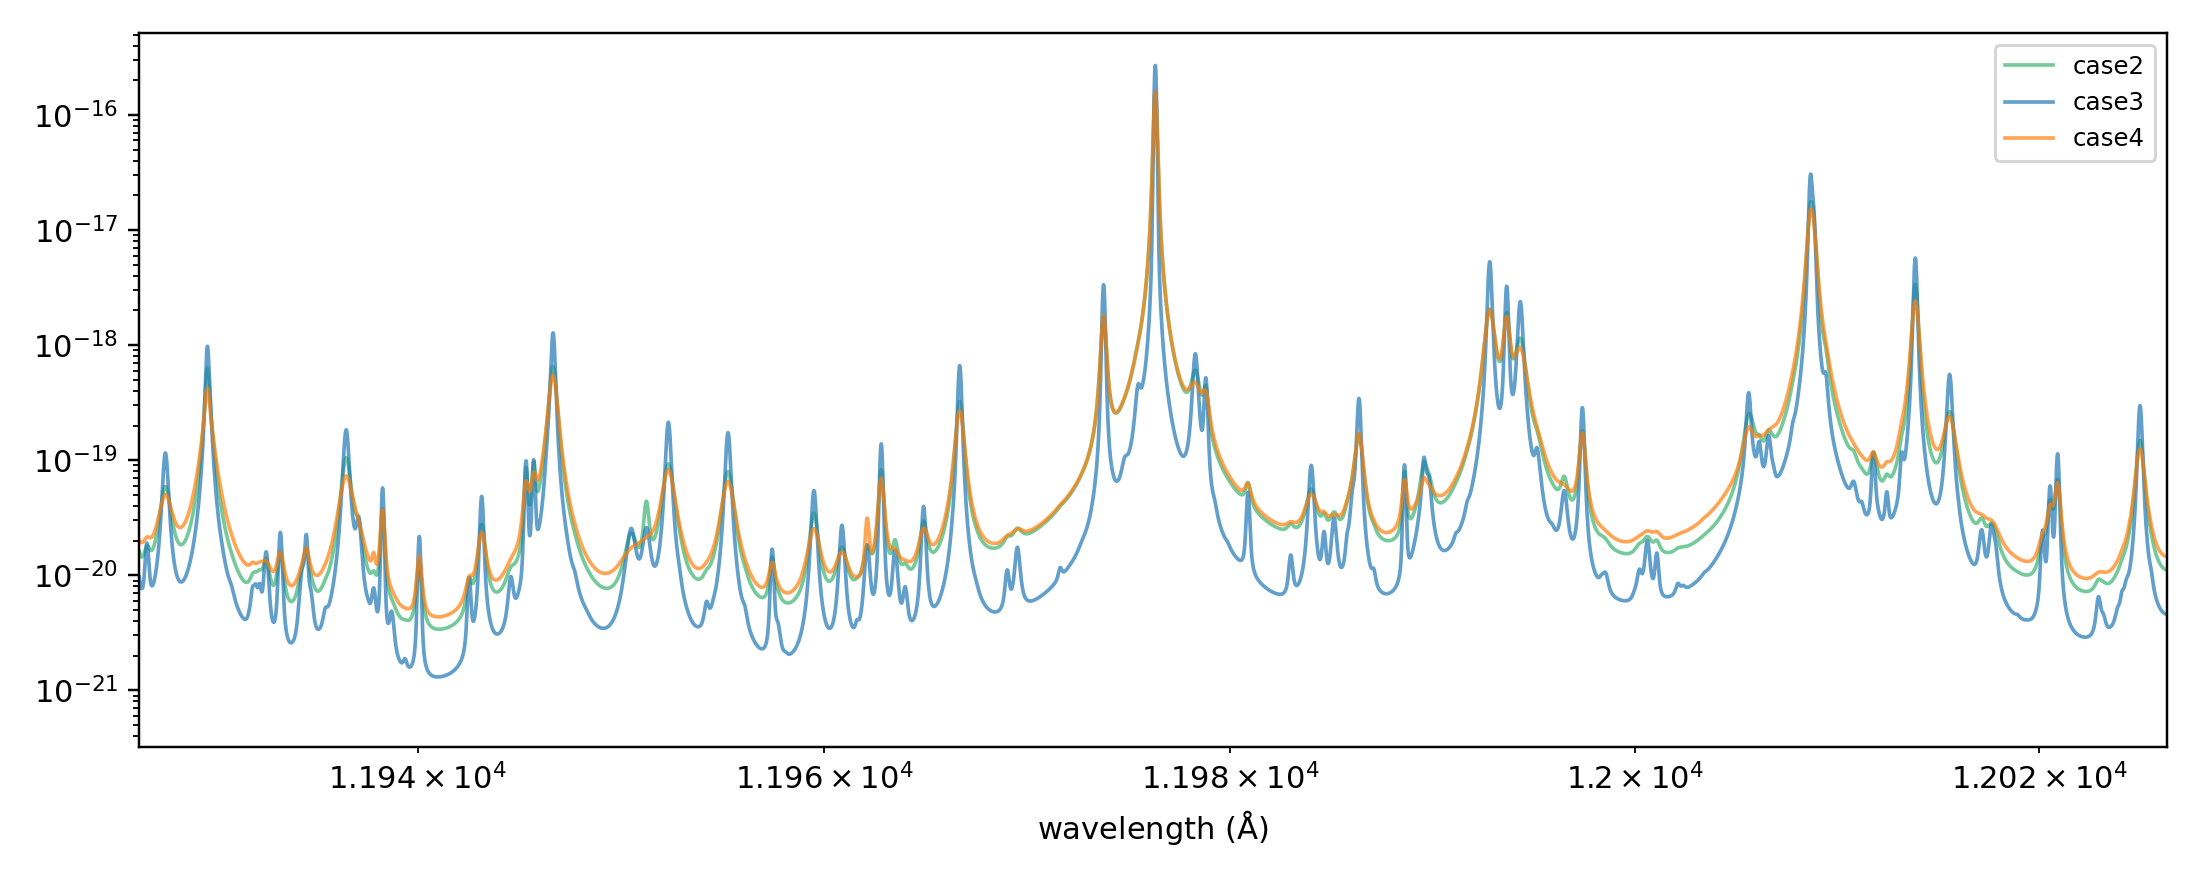

In [96]:
#3 cases at 10000 K

petit_exojaxdir=path_pRT+"input_data/opacities/lines/line_by_line/Fe_exojax/"

with open(petit_exojaxdir+"wlen_3cases.dat", 'rb') as w:
    contentw = np.fromfile(w, dtype=np.float64)
    wav=np.array(contentw,dtype=np.float64) #cm

fn_exo2="sigma_99_10000.K_0.100000bar10000K2.dat" #1.000000bar
fn_exo3="sigma_99_10000.K_0.100000bar10000K3.dat"
fn_exo4="sigma_99_10000.K_0.100000bar10000K4.dat"
species_mass=55.847 #Amol
with open(petit_exojaxdir+fn_exo2, 'rb') as f:
    xs2=np.array(np.fromfile(f, dtype=np.float64))*species_mass*ucgs
with open(petit_exojaxdir+fn_exo3, 'rb') as f:
    xs3=np.array(np.fromfile(f, dtype=np.float64))*species_mass*ucgs
with open(petit_exojaxdir+fn_exo4, 'rb') as f:
    xs4=np.array(np.fromfile(f, dtype=np.float64))*species_mass*ucgs

fig, ax1=plt.subplots(figsize=(10,4), tight_layout=True) #15, 5

ax1.plot(wav*1.e8, xs2, lw=1.2, linestyle='-', alpha=0.7, label='case2', color='mediumseagreen')
ax1.plot(wav*1.e8, xs3, lw=1.2, linestyle='-', alpha=0.7, label='case3')
ax1.plot(wav*1.e8, xs4, lw=1.2, linestyle='-', alpha=0.7, label='case4')

#ax1.plot(wav_yk, ko_ish_wo_VIS[:,1], '-', lw=0.5, label='(xH,xHe,xH2)=(0.05,0.005,0.1), kawashima, inverted, w/o opt lines', alpha=0.8)

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("wavelength ($\mathrm{\AA}$)")
ax1.set_xlim(11000, 13000)
ax1.set_xlim(11976.3233-50, 11976.3233+50)
ax1.legend(fontsize=8)

#plt.subplots_adjust(hspace=.05)
#plt.savefig(path_fig+'comp_diff_Fe'+'_optical_from_different_wav_rep'+'.pdf') #out_suffix
plt.show()

<IPython.core.display.Javascript object>


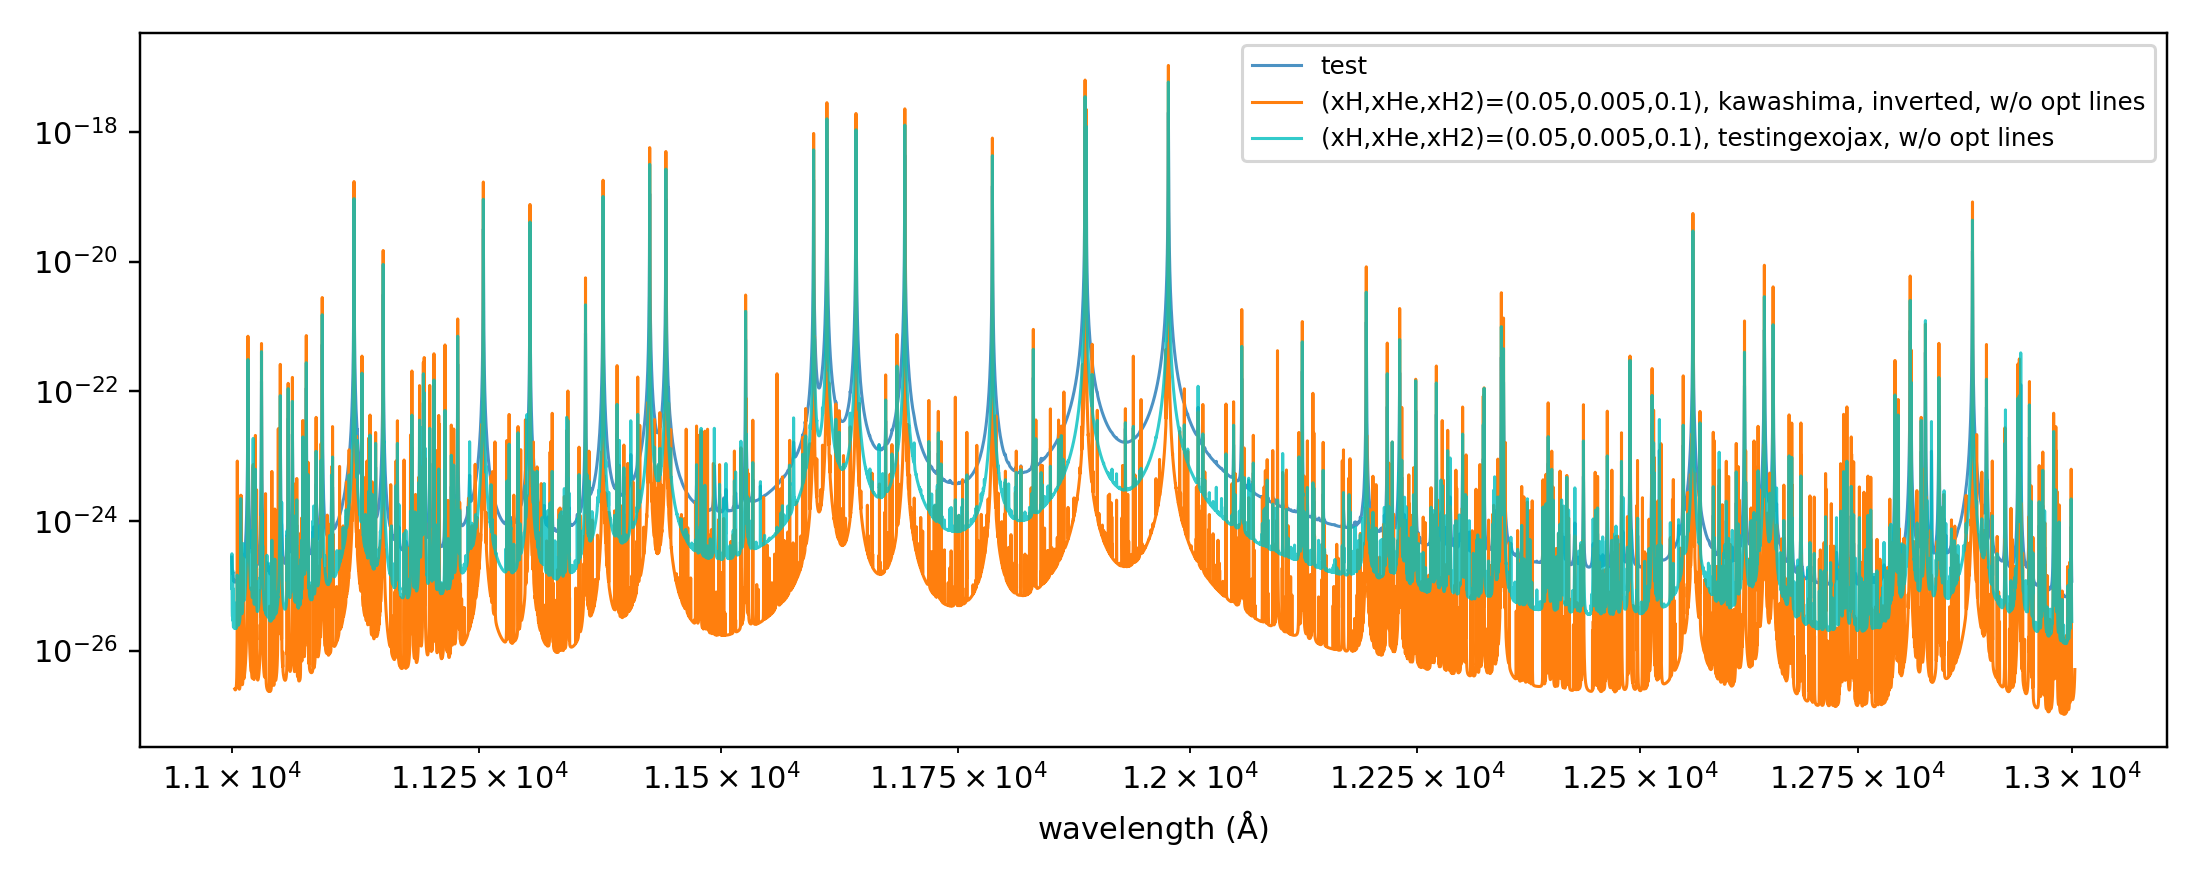

In [174]:
fig, ax1=plt.subplots(figsize=(10,4), tight_layout=True) #15, 5

ax1.plot(wav*1.e8, xs, lw=1, linestyle='-', alpha=0.8, label='test')#, 'r'

#ax1.plot(wav_yk, ko_sol_inverted[:,1], lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), kawashima, inverted') #, alpha=0.0)#
ax1.plot(wav_yk, ko_ish_wo_VIS[:,1], '-', color='C1', lw=1, label='(xH,xHe,xH2)=(0.05,0.005,0.1), kawashima, inverted, w/o opt lines')
#ax1.plot(wav*1.e8, xsyobi, 'k', lw=1, linestyle='-', alpha=0.8, label='(xH,xHe,xH2)=(0.0,0.16,0.84), testingexojax, w/o opt lines')
ax1.plot(wav*1.e8, xs_takofrac, 'c', lw=1, linestyle='-', alpha=0.8, label='(xH,xHe,xH2)=(0.05,0.005,0.1), testingexojax, w/o opt lines')
#ax1.plot(wav*1.e8, xsyobi2, 'slateblue', lw=1, linestyle='-', alpha=0.8, label='(xH,xHe,xH2)=(0.0,0.0016,0.0084), testingexojax, w/o opt lines')

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("wavelength ($\mathrm{\AA}$)")
ax1.legend(fontsize=8)

#plt.subplots_adjust(hspace=.05)
#plt.savefig(path_fig+'comp_diff_Fe'+'_optical_from_different_wav_rep'+'.pdf') #out_suffix
plt.show()

In [165]:
plt.savefig(path_fig+'comp_diff_Fe'+'_optical_from_different_wav_rep2'+'.pdf') #out_suffix


In [144]:
plt.savefig(path_fig+'comp_diff_Fe'+'_KawashimaRange'+'.pdf') #out_suffix

# 全波長のvisual check
可視側がどうなってるか  

In [ ]:
fig, ax1=plt.subplots(figsize=(10,4), tight_layout=True) #15, 5

ax1.plot(wav_4204596*1.e8, xs_wopt, lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), tako, w/ opt lines')
#ax1.plot(wav_excerpt*1.e8, xs_ghalf_excerpt, lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), tako, half-gamma')
#ax1.plot(wav_opt*1.e8, xs_opt, lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), tako, only opt lines')

ax1.plot(wav_yk, ko_sol_inverted[:,1], lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), inverted')
ax1.plot(wav_yk, ko_ish_wo_VIS[:,1], '-.', lw=1, label='(xH,xHe,xH2)=(0.05,0.005,0.1), inverted, w/o opt lines')

ax1.set_xlim(xrg)
#ax1.set_ylim(yrg)

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("wavelength ($\AA$)")
ax1.legend()

#plt.subplots_adjust(hspace=.05)
plt.savefig(path_fig+'wopt_whole_wavelength_check_long.pdf')
#plt.show()

<IPython.core.display.Javascript object>